In [67]:
# ───────────────────────────────────────────────
# Cell 1 :  Imports & Global Configuration
# ───────────────────────────────────────────────
import os, glob, re, uuid, pickle, shutil
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from shapely.geometry import (
    Polygon, MultiPolygon, Point, LineString, MultiLineString
)
from shapely.ops import unary_union
from shapely.validation import make_valid
from roifile import ImagejRoi
from tqdm import tqdm

# ─── Paths ─────────────────────────────────────
MODEL_DIR= os.path.join(BASE_DIR, "models")          # everything we generate
PATCH_DIR= os.path.join(MODEL_DIR, "patches")
RAW_CSV_DIR = os.path.join(CSV_DIR, "_original_unfiltered")

# --- Directories --- 
BASE_DIR           = r"D:\PSM\SST_images\SST3"
ROI_DIR            = os.path.join(BASE_DIR, "avg",    "Processed_ROIs")
REFINED_PYR_DIR    = os.path.join(ROI_DIR,  "refinedPyrimidale")
CSV_DIR            = os.path.join(BASE_DIR, "csvs")
AVG_DIR            = os.path.join(BASE_DIR, "avg")
AVG_BC_DIR         = os.path.join(AVG_DIR,  "BC_corrected")
RESULTS_XLSX       = os.path.join(BASE_DIR, "results", "processed_results.xlsx")
ROI_MEASURE_CSV    = os.path.join(AVG_DIR,  "roi_measurements.csv")

# --- Parameters ---
VOLUME_CUTOFF = 80                  # µm³
PSM_LETTERS   = list("EFIKLMNOPQSTUW")   # iterate letters
PSM_NUMBERS   = range(1,6)          # iterate numbers 1–5
GROUP_C       = set(['K','L','M','N','O','P','Q'])
GROUP_SE      = set(['E','F','I','S','T','U','W'])
# keep these two lines at top so every cell can import them
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(PATCH_DIR, exist_ok=True)

# ─── Constants ─────────────────────────────────
VOLUME_CUTOFF    = 80
PATCH_SIDE       = 64      # XY size
PATCH_DEPTH      = 3       # ±Z
PATCH_PADDING    = 4       # background ring


In [68]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell 2: Helper Functions
# ─────────────────────────────────────────────────────────────────────────────
def _make_valid(poly: Polygon|MultiPolygon):
    if poly.is_valid: return poly
    fixed = poly.buffer(0)
    return fixed if fixed.is_valid else make_valid(poly)

def _outer_boundary(poly: Polygon|MultiPolygon):
    if isinstance(poly, Polygon): return poly.exterior
    return unary_union([p.exterior for p in poly.geoms])

def round_coords(coords):
    return np.round(coords).astype(int)

def save_pyr_roi(poly, out_dir, base_id):
    os.makedirs(out_dir, exist_ok=True)
    pts = round_coords(np.array(poly.exterior.coords))
    ImagejRoi.frompoints(pts).tofile(
        os.path.join(out_dir, f"Red_{base_id}_s_pyrimidale.roi")
    )

def extract_shared_boundary(p1,p2):
    b = p1.intersection(p2)
    if b.is_empty: return None
    if b.geom_type in ("LineString","MultiLineString"): return b
    if b.geom_type=="GeometryCollection":
        lines=[g for g in b.geoms if g.geom_type in ("LineString","MultiLineString")]
        return MultiLineString(lines) if lines else None
    return None

def generate_file_paths(base_id):
    return {
        "full_roi"   : os.path.join(ROI_DIR,  f"Red_{base_id}_full.roi"),
        "oriens_roi" : os.path.join(ROI_DIR,  f"Red_{base_id}_s_oriens.roi"),
        "radiatum_roi":os.path.join(ROI_DIR,  f"Red_{base_id}_s_radiatum.roi")
    }

def create_base_id(letter,number):
    return f"PSM_{letter}_CA1_10x_{str(number).zfill(2)}"

def process_rois(base_id):
    fps = generate_file_paths(base_id)
    try:
        full = _make_valid(Polygon(round_coords(
            ImagejRoi.fromfile(fps["full_roi"]).coordinates())))
        ori  = _make_valid(Polygon(round_coords(
            ImagejRoi.fromfile(fps["oriens_roi"]).coordinates())))
        rad  = _make_valid(Polygon(round_coords(
            ImagejRoi.fromfile(fps["radiatum_roi"]).coordinates())))
        pyr  = _make_valid(full.difference(unary_union([ori,rad])))
        save_pyr_roi(pyr, REFINED_PYR_DIR, base_id)
        return {"full":full,"oriens":ori,"pyrimidale":pyr,"radiatum":rad}
    except Exception as e:
        print(f"Error processing ROIs for {base_id}: {e}")
        return None

def calculate_shared_boundaries(polys):
    sb = {
        ('oriens','pyrimidale')   : extract_shared_boundary(polys['oriens'],polys['pyrimidale']),
        ('pyrimidale','radiatum'): extract_shared_boundary(polys['pyrimidale'],polys['radiatum']),
    }
    for k,b in sb.items():
        status = "valid" if b and not b.is_empty else "invalid/empty"
        #print(f"Shared {k}: {status}")
    return sb

def calculate_relative_positions(base_id, points, polys, shared):
    positions = []
    for x, y in points[['X', 'Y']].values:
        pt = Point(x, y)
        assigned = False

        for name in ['oriens', 'pyrimidale', 'radiatum', 'full']:  # priority order
            poly = polys[name]
            if not poly.covers(pt):
                continue

            if name == 'pyrimidale':
                d1 = pt.distance(shared[('oriens', 'pyrimidale')])
                d2 = pt.distance(shared[('pyrimidale', 'radiatum')])
                t = d1 + d2
                pct = (d1 / t) * 100 if t else None
            elif name in ['oriens', 'radiatum']:
                key = ('oriens', 'pyrimidale') if name == 'oriens' else ('pyrimidale', 'radiatum')
                sb = shared.get(key)
                if not sb or sb.is_empty:
                    continue
                outer = _outer_boundary(poly)
                adj = outer.difference(sb)
                d1 = pt.distance(sb)
                d2 = pt.distance(adj)
                t = d1 + d2
                pct = (d1 / t) * 100 if t else None
            else:
                pct = None

            positions.append({'X': x, 'Y': y, 'ROI': name, 'Position%': pct})
            assigned = True
            break

        if not assigned:
            print("Point (%.1f, %.1f) not assigned to any ROI" % (x, y))

    return positions

In [69]:
# ───────────────────────────────────────────────
# Cell 3 :  One-time QC folder / back-up setup
# ───────────────────────────────────────────────
for d in [RAW_CSV_DIR, MODEL_DIR, PATCH_DIR]:
    os.makedirs(d, exist_ok=True)

# back-up raw *Statistics_for_Red_*.csv the first time only
for csv in glob.glob(os.path.join(CSV_DIR, "Statistics_for_Red_*.csv")):
    dst = os.path.join(RAW_CSV_DIR, os.path.basename(csv))
    if not os.path.exists(dst):
        shutil.copy2(csv, dst)
print("✅ Back-up check complete.")


✅ Back-up check complete.


In [143]:
# ─────────────────────────────────────────────────────────────
# Cell 4 :  Extract 3-D patches + engineered features (radiatum)
# ─────────────────────────────────────────────────────────────
from skimage.io import imread
from skimage.feature import local_binary_pattern
from skimage.measure import regionprops
from skimage.morphology import binary_dilation, disk
from scipy.ndimage import binary_fill_holes
from joblib import Parallel, delayed
import pyarrow as pa, pyarrow.parquet as pq
import pandas as pd

def skip_or_save_patch(pid: str, patch: np.ndarray):
    f = os.path.join(PATCH_DIR, pid + ".npy")
    if os.path.exists(f):  # already made → skip writing
        return
    np.save(f, patch, allow_pickle=False)

def extract_shape_features(mask: np.ndarray):
    props = regionprops(mask.astype(int))
    if not props:
        return {}
    p = props[0]
    circ = (4 * np.pi * p.area) / (p.perimeter ** 2) if p.perimeter else 0
    return {
        "eccentricity": p.eccentricity,
        "solidity": p.solidity,
        "extent": p.extent,
        "circularity": circ,
        "major_axis_length": p.major_axis_length,
        "minor_axis_length": p.minor_axis_length
    }

def extract_bg_features(img: np.ndarray, mask: np.ndarray):
    ring = binary_dilation(mask, disk(PATCH_PADDING)) & ~mask
    vals = img[ring]
    if vals.size == 0:
        return {
            "background_mean": 0,
            "background_std": 1,
            "background_contrast_ratio": 0
        }
    bg_mean, bg_std = vals.mean(), vals.std() or 1
    return {
        "background_mean": bg_mean,
        "background_std": bg_std,
        "background_contrast_ratio": (img[mask].mean() - bg_mean) / bg_std
    }

def process_object(row, stack, base_id: str, idx: int):
    # Derive a deterministic patch_id from base_id and object index
    pid = f"{base_id}_{idx}"
    # Coordinates
    zc, yc, xc = map(int, [row.Z, row.Y, row.X])
    z0, z1 = max(0, zc - PATCH_DEPTH), min(stack.shape[0], zc + PATCH_DEPTH + 1)
    y0, y1 = max(0, yc - PATCH_SIDE // 2), min(stack.shape[1], yc + PATCH_SIDE // 2)
    x0, x1 = max(0, xc - PATCH_SIDE // 2), min(stack.shape[2], xc + PATCH_SIDE // 2)
    # Skip if too close to an edge
    if (z1 - z0) < 3 or (y1 - y0) < PATCH_SIDE // 2 or (x1 - x0) < PATCH_SIDE // 2:
        return None
    patch = stack[z0:z1, y0:y1, x0:x1].astype(np.uint8)
    skip_or_save_patch(pid, patch)

    mip = patch.max(axis=0)
    mask = binary_fill_holes(mip > np.percentile(mip, 95))

    feats = {
        "patch_id": pid,
        "base_id": base_id,
        "obj_idx": idx,
        "volume": row['Volume (µm^3)'],
        "intensity": patch.mean(),
        "texture": local_binary_pattern(mip, 8, 1).mean(),
        "contrast": mip.std(),
        "edge_strength": np.abs(np.gradient(mip.astype(float))).mean(),
        "skewness": ((mip - mip.mean()) ** 3).mean() / (mip.std() ** 3 + 1e-5),
        **extract_shape_features(mask),
        **extract_bg_features(mip, mask)
    }
    return feats

def handle_csv(csv_path: str):
    m = re.search(r"Red_(PSM_[A-Z]_CA1_10x_\d{2})_", os.path.basename(csv_path))
    if not m:
        return []
    base_id = m.group(1)
    stack_path = os.path.join(BASE_DIR, "Red", f"Red_{base_id}.tif")
    if not os.path.exists(stack_path):
        return []
    stack = imread(stack_path)
    df = pd.read_csv(csv_path)
    rois = process_rois(base_id)
    shared = calculate_shared_boundaries(rois)
    pos = calculate_relative_positions(base_id, df, rois, shared)
    radiatum_idxs = [i for i, p in enumerate(pos) if p['ROI'] == 'radiatum']
    results = []
    for i in radiatum_idxs:
        if df.loc[i, 'Volume (µm^3)'] <= VOLUME_CUTOFF:
            continue
        rec = process_object(df.loc[i], stack, base_id, i)
        if rec:
            results.append(rec)
    return results

# ─── Load any existing feature table ────────────────────────────────────────
FEATURE_PATH = os.path.join(MODEL_DIR, "radiatum_patch_features.parquet")
try:
    existing_df = pd.read_parquet(FEATURE_PATH)
    existing_ids = set(existing_df['patch_id'])
except FileNotFoundError:
    existing_df = pd.DataFrame()
    existing_ids = set()

# ─── Generate new features in parallel ──────────────────────────────────────
csvs = sorted(glob.glob(os.path.join(RAW_CSV_DIR, "Statistics_for_Red_*.csv")))
flat_new = Parallel(n_jobs=-1)(
    delayed(handle_csv)(c) for c in tqdm(csvs)
)
flat_new = [r for sub in flat_new for r in sub]

# ─── Filter out any patches we’ve already processed ─────────────────────────
flat_filtered = [r for r in flat_new if r['patch_id'] not in existing_ids]

# ─── Combine with existing records ──────────────────────────────────────────
if not existing_df.empty:
    combined_df = pd.concat([existing_df, pd.DataFrame(flat_filtered)], ignore_index=True)
else:
    combined_df = pd.DataFrame(flat_filtered)

# ─── Overwrite the feature table with the updated DataFrame ────────────────
pq.write_table(pa.Table.from_pandas(combined_df), FEATURE_PATH)
print(f"✅ Features table now has {len(combined_df)} rows.")

# ─── Check for any annotated patches missing from the feature table ─────────
annot = pd.read_csv(ANNOT_CSV) if os.path.exists(ANNOT_CSV) else pd.DataFrame()
missing = set(annot.get('patch_id', [])) - set(combined_df['patch_id'])
print(f"🔍 Missing feature rows for {len(missing)} annotated patches.")



100%|██████████| 114/114 [00:03<00:00, 35.16it/s]


✅ Features table now has 1177 rows.
🔍 Missing feature rows for 0 annotated patches.


In [61]:
'''import pandas as pd

feat_df = pd.read_parquet(r"D:\PSM\SST_images\SST3\models\radiatum_patch_features.parquet")
feat_df['object_key'] = feat_df['base_id'].astype(str) + "_" + feat_df['obj_idx'].astype(str)

print("Total patches:", len(feat_df))
print("Unique objects:", feat_df['object_key'].nunique())


🔍 Total patches: 1814
🔍 Unique objects: 1177


In [62]:
'''dedup_df = feat_df.drop_duplicates(subset='object_key', keep='first').drop(columns=['object_key'])
dedup_path = r"D:\PSM\SST_images\SST3\models\radiatum_patch_features_deduped.parquet"
dedup_df.to_parquet(dedup_path, index=False)
print("✅ Deduplicated feature table saved:", dedup_path)


✅ Deduplicated feature table saved: D:\PSM\SST_images\SST3\models\radiatum_patch_features_deduped.parquet


In [63]:
'''import os
import shutil
from datetime import datetime

# Paths
model_dir = r"D:\PSM\SST_images\SST3\models"
dedup_path = os.path.join(model_dir, "radiatum_patch_features_deduped.parquet")
original_path = os.path.join(model_dir, "radiatum_patch_features.parquet")

# Create timestamp for archival
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
archived_path = os.path.join(model_dir, f"radiatum_patch_features_old_{timestamp}.parquet")

# Rename original file to archive
if os.path.exists(original_path):
    shutil.move(original_path, archived_path)
    print("📦 Archived original to:", archived_path)

# Rename deduplicated file to original name
shutil.move(dedup_path, original_path)
print("✅ Renamed deduplicated file to:", original_path)


📦 Archived original to: D:\PSM\SST_images\SST3\models\radiatum_patch_features_old_20250601_1444.parquet
✅ Renamed deduplicated file to: D:\PSM\SST_images\SST3\models\radiatum_patch_features.parquet


In [57]:
'''# --- TEMPORARY RESTORE OF ANNOTATIONS FROM QUARANTINE ---
QUARANTINE_PATH = ANNOT_CSV.replace(".csv", "_quarantine_missing.csv")

if os.path.exists(QUARANTINE_PATH):
    print("♻️ Restoring annotations from quarantine...")
    df_quarantine = pd.read_csv(QUARANTINE_PATH)
    df_quarantine.to_csv(ANNOT_CSV, index=False)
    print("✅ Restored {} annotations to {}".format(len(df_quarantine), ANNOT_CSV))
else:
    raise FileNotFoundError("No quarantine file found at {}".format(QUARANTINE_PATH))


♻️ Restoring annotations from quarantine...
✅ Restored 540 annotations to D:\PSM\SST_images\SST3\models\annotated_labels.csv


In [60]:
'''import os, hashlib
import pandas as pd
import numpy as np
from tqdm import tqdm

# === CONFIG ===
PATCH_DIR = os.path.join(MODEL_DIR, "patches")  # Adjust if needed
QUARANTINE_CSV = os.path.join(MODEL_DIR, "annotated_labels_quarantine_missing.csv")
ANNOT_CSV = os.path.join(MODEL_DIR, "annotated_labels.csv")

# === Step 1: Load quarantined annotations ===
try:
    quarantine_df = pd.read_csv(QUARANTINE_CSV)
except Exception as e:
    print("❌ Failed to load:", QUARANTINE_CSV)
    raise e

print("🔍 Quarantined annotations:", len(quarantine_df))

# === Step 2: Hash all patch files ===
def hash_patch(path):
    try:
        data = np.load(path)
        return hashlib.sha1(data.tobytes()).hexdigest()
    except Exception:
        return None

print("🔁 Hashing all patches...")
hash_map = {}
for fname in tqdm(os.listdir(PATCH_DIR)):
    if not fname.endswith(".npy"):
        continue
    path = os.path.join(PATCH_DIR, fname)
    h = hash_patch(path)
    if h:
        hash_map[h] = fname.replace(".npy", "")

# === Step 3: Remap legacy annotations by hash ===
migrated = []
unmatched = []

print("🔁 Attempting hash remap using raw pixel values...")
for _, row in quarantine_df.iterrows():
    legacy_pid = row['patch_id']
    legacy_path = os.path.join(PATCH_DIR, legacy_pid + ".npy")
    h = hash_patch(legacy_path)
    if h in hash_map:
        row['patch_id'] = hash_map[h]
        migrated.append(row)
    else:
        unmatched.append(row)

# === Step 4: Save results ===
print("✅ Migrated {} annotations via hash remap.".format(len(migrated)))
print("🧪 Quarantined {} unmatched.".format(len(unmatched)))

# Load existing annotations (may be empty)
try:
    existing = pd.read_csv(ANNOT_CSV)
except Exception:
    existing = pd.DataFrame(columns=row.index)

# Combine and save
updated = pd.concat([existing, pd.DataFrame(migrated)], ignore_index=True)
updated.to_csv(ANNOT_CSV, index=False)
pd.DataFrame(unmatched).to_csv(QUARANTINE_CSV, index=False)

print("💾 Updated annotations saved to:")
print("   - Main →", ANNOT_CSV)
print("   - Quarantine →", QUARANTINE_CSV)


🔍 Quarantined annotations: 540
🔁 Hashing all patches...



100%|██████████| 4731/4731 [00:00<00:00, 12865.60it/s]


🔁 Attempting hash remap using raw pixel values...
✅ Migrated 540 annotations via hash remap.
🧪 Quarantined 0 unmatched.
💾 Updated annotations saved to:
   - Main → D:\PSM\SST_images\SST3\models\annotated_labels.csv
   - Quarantine → D:\PSM\SST_images\SST3\models\annotated_labels_quarantine_missing.csv


In [59]:
'''import pandas as pd

# Paths
OLD_FEATURES_PATH = os.path.join(MODEL_DIR, "radiatum_patch_features.parquet")
DEDUPED_FEATURES_PATH = os.path.join(MODEL_DIR, "radiatum_patch_features_deduped.parquet")

# Load full + deduped
df_all = pd.read_parquet(OLD_FEATURES_PATH)
df_deduped = pd.read_parquet(DEDUPED_FEATURES_PATH)

# Create mapping: hash → canonical patch_id (from deduped)
hash_to_canonical = {}
for row in df_deduped.itertuples():
    hashval = hashlib.sha1(np.load(os.path.join(PATCH_DIR, row.patch_id + ".npy")).tobytes()).hexdigest()
    hash_to_canonical[hashval] = row.patch_id

# Load annotations
annot = pd.read_csv(ANNOT_CSV)
legacy_ids = annot[~annot['patch_id'].str.match(r'PSM_[A-Z]_CA1_10x_\d{2}_\d+')]['patch_id'].unique()

# Attempt migration using original (legacy) patch hashes
print("🔁 Attempting hash remap using full feature set...")
id_to_hash = {}
for row in df_all.itertuples():
    patch_path = os.path.join(PATCH_DIR, row.patch_id + ".npy")
    if os.path.exists(patch_path):
        id_to_hash[row.patch_id] = hashlib.sha1(np.load(patch_path).tobytes()).hexdigest()

migrated_rows = []
quarantine_rows = []

for _, row in annot.iterrows():
    pid = row['patch_id']
    h = id_to_hash.get(pid)
    new_pid = hash_to_canonical.get(h)
    if new_pid:
        row['patch_id'] = new_pid
        migrated_rows.append(row)
    else:
        quarantine_rows.append(row)

# Save
pd.DataFrame(migrated_rows).to_csv(ANNOT_CSV, index=False)
pd.DataFrame(quarantine_rows).to_csv(ANNOT_CSV.replace(".csv", "_quarantine.csv"), index=False)

print("✅ Migrated {} annotations via hash remap.".format(len(migrated_rows)))
print("🧪 Quarantined {} unmatched.".format(len(quarantine_rows)))


🔁 Attempting hash remap using full feature set...
✅ Migrated 0 annotations via hash remap.
🧪 Quarantined 540 unmatched.


In [65]:
'''import os
import pandas as pd

# --- Paths ---
ANNOT_CSV = r"D:\PSM\SST_images\SST3\models\annotated_labels.csv"
FEATURE_PARQUET = r"D:\PSM\SST_images\SST3\models\radiatum_patch_features.parquet"
PATCH_DIR = r"D:\PSM\SST_images\SST3\models\patches"  # Adjust if needed

# --- Load annotations and features ---
annot_df = pd.read_csv(ANNOT_CSV)
feat_df = pd.read_parquet(FEATURE_PARQUET)

# --- Build valid patch ID sets ---
valid_patch_ids = set(feat_df['patch_id'])
existing_patch_files = {f.replace('.npy', '') for f in os.listdir(PATCH_DIR) if f.endswith('.npy')}
valid_patch_ids &= existing_patch_files  # Only those with both features and .npy

# --- Filter annotations ---
is_valid = annot_df['patch_id'].isin(valid_patch_ids)
valid_annot = annot_df[is_valid].copy()
quarantine_annot = annot_df[~is_valid].copy()

# --- Save ---
valid_annot.to_csv(ANNOT_CSV, index=False)
quarantine_path = ANNOT_CSV.replace(".csv", "_quarantine_invalid.csv")
quarantine_annot.to_csv(quarantine_path, index=False)

# --- Summary ---
print("✅ Valid annotations:", len(valid_annot))
print("🧪 Quarantined invalid annotations:", len(quarantine_annot))
print("💾 Saved updated annotations to:\n  - Main → {}\n  - Quarantine → {}".format(ANNOT_CSV, quarantine_path))


✅ Valid annotations: 0
🧪 Quarantined invalid annotations: 540
💾 Saved updated annotations to:
  - Main → D:\PSM\SST_images\SST3\models\annotated_labels.csv
  - Quarantine → D:\PSM\SST_images\SST3\models\annotated_labels_quarantine_invalid.csv


In [66]:
'''import os
import numpy as np
import pandas as pd
from tqdm import tqdm

# --- Paths ---
FEATURE_PARQUET = r"D:\PSM\SST_images\SST3\models\radiatum_patch_features.parquet"
PATCH_DIR = r"D:\PSM\SST_images\SST3\models\patches"  # Adjust if needed
SOURCE_PATCH_DIR = r"D:\PSM\SST_images\SST3\models\all_patches"  # The big archive of all original patches

# --- Load feature list ---
feat_df = pd.read_parquet(FEATURE_PARQUET)

# --- Ensure destination exists ---
os.makedirs(PATCH_DIR, exist_ok=True)

# --- Copy or link only needed patches ---
copied = 0
for patch_id in tqdm(feat_df['patch_id'].unique(), desc="🔁 Copying patch files"):
    src = os.path.join(SOURCE_PATCH_DIR, patch_id + ".npy")
    dst = os.path.join(PATCH_DIR, patch_id + ".npy")
    if not os.path.exists(dst) and os.path.exists(src):
        np.save(dst, np.load(src, allow_pickle=False))
        copied += 1

print("✅ Rebuilt patch directory with {} valid .npy files.".format(copied))



🔁 Copying patch files: 100%|██████████| 1177/1177 [00:00<00:00, 65391.03it/s]

✅ Rebuilt patch directory with 0 valid .npy files.


In [58]:
'''import hashlib
import numpy as np

def hash_patch(file_path):
    try:
        data = np.load(file_path)
        return hashlib.sha1(data.tobytes()).hexdigest()
    except Exception:
        return None

# Load old annotations
annot = pd.read_csv(ANNOT_CSV)
legacy_ids = annot[~annot['patch_id'].str.match(r'PSM_[A-Z]_CA1_10x_\d{2}_\d+')]['patch_id'].unique()

FEATURE_PATH = os.path.join(MODEL_DIR, "radiatum_patch_features_deduped.parquet")
valid_patch_ids = set(pd.read_parquet(FEATURE_PATH)['patch_id'])

# Hash canonical patches
print("🔍 Hashing canonical patches...")
canonical_map = {}
for fname in os.listdir(PATCH_DIR):
    if fname.endswith('.npy') and fname.startswith('PSM_'):
        pid = fname.replace('.npy', '')
        if pid not in valid_patch_ids:
            continue  # skip duplicates or outdated patches
        h = hash_patch(os.path.join(PATCH_DIR, fname))
        if h:
            canonical_map[h] = pid

# Prepare for migration
migrated = 0
new_rows = []
quarantine_rows = []

print("🔁 Attempting to map old annotations to new canonical patches...")
for _, row in annot.iterrows():
    pid = row['patch_id']
    if pid in legacy_ids:
        old_path = os.path.join(PATCH_DIR, pid + '.npy')
        h = hash_patch(old_path)
        if h in canonical_map:
            row['patch_id'] = canonical_map[h]
            new_rows.append(row)
            migrated += 1
        else:
            quarantine_rows.append(row)
    else:
        new_rows.append(row)

print("✅ Migrated {} annotations to canonical patch IDs.".format(migrated))
print("🧪 Quarantined {} unmatched legacy annotations.".format(len(quarantine_rows)))

# Save main + quarantine annotation tables
pd.DataFrame(new_rows).to_csv(ANNOT_CSV, index=False)
pd.DataFrame(quarantine_rows).to_csv(ANNOT_CSV.replace(".csv", "_quarantine.csv"), index=False)

print("💾 Updated annotations saved to:")
print("   - Main: {}".format(ANNOT_CSV))
print("   - Quarantine: {}".format(ANNOT_CSV.replace('.csv', '_quarantine.csv')))


🔍 Hashing canonical patches...
🔁 Attempting to map old annotations to new canonical patches...
✅ Migrated 0 annotations to canonical patch IDs.
🧪 Quarantined 0 unmatched legacy annotations.
💾 Updated annotations saved to:
   - Main: D:\PSM\SST_images\SST3\models\annotated_labels.csv
   - Quarantine: D:\PSM\SST_images\SST3\models\annotated_labels_quarantine.csv


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


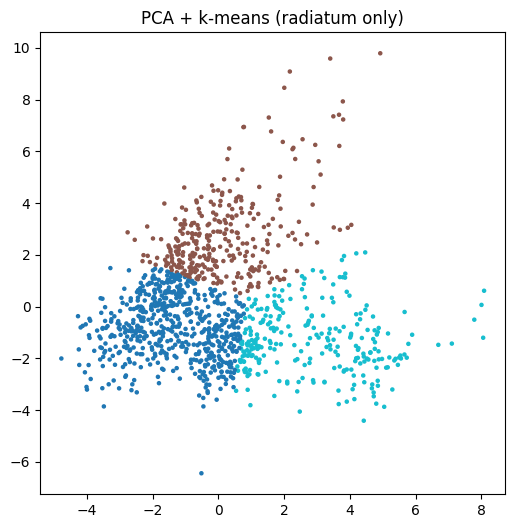

✅ PCA + clustering done. ‘radiatum_patch_features.parquet’ now has PC1, PC2, cluster, and target.
    Junk fraction = 0.263


In [71]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell 5: PCA + k-means + save back into radiatum_patch_features.parquet
# ─────────────────────────────────────────────────────────────────────────────
import os
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
import pickle

# ─── Paths ────────────────────────────────────────────────────────────────────
MODEL_DIR    = r"D:\PSM\SST_images\SST3\models"
FEATURE_FILE = os.path.join(MODEL_DIR, "radiatum_patch_features.parquet")
# (We will overwrite FEATURE_FILE in place)
CLASSIFIER_OUT = os.path.join(MODEL_DIR, "neurite_filter.pkl")

# ─── Load features ───────────────────────────────────────────────────────────
feat_df = pq.read_table(FEATURE_FILE).to_pandas()

# ─── Define exactly which columns we expect now (all 15 + ROI-derived) ────────
features = [
    'volume',
    'intensity',
    'texture',
    'contrast',
    'edge_strength',
    'skewness',
    'background_mean',
    'background_std',
    'background_contrast_ratio',
    'eccentricity',
    'solidity',
    'extent',
    'circularity',
    'major_axis_length',
    'minor_axis_length'
]

# ─── 1) Normalize all selected features ───────────────────────────────────────
X = StandardScaler().fit_transform(feat_df[features])

# ─── 2) PCA to 2D for visualization ───────────────────────────────────────────
pca2 = PCA(n_components=2).fit_transform(X)
feat_df['PC1'] = pca2[:, 0]
feat_df['PC2'] = pca2[:, 1]

# ─── 3) k-means (in the 2D PC space) ─────────────────────────────────────────
k = 3
labels = KMeans(n_clusters=k, random_state=0).fit_predict(pca2)
feat_df['cluster'] = labels

# ─── (Optional) Visualize the PCA → k-means result ────────────────────────────
fig, ax = plt.subplots(figsize=(6, 6))
scatter = ax.scatter(feat_df['PC1'], feat_df['PC2'], c=labels, s=5, cmap='tab10')
ax.set_title("PCA + k-means (radiatum only)")
plt.show()

# ─── 4) Train a (mini) classifier on “junk vs not” if you like ───────────────
#  (Here we’ll assume cluster 1 = “neurite/cell” and everything else is “junk”;
#  you can change NEURITE_CLUSTERS after looking at the plot above.)
NEURITE_CLUSTERS = {1}
feat_df['target'] = feat_df['cluster'].isin(NEURITE_CLUSTERS).astype(int)

clf = GradientBoostingClassifier(random_state=0).fit(X, feat_df['target'])

# ─── 5) Save the classifier to disk ─────────────────────────────────────────
with open(CLASSIFIER_OUT, "wb") as f:
    pickle.dump(clf, f)

# ─── 6) Overwrite feature file so it now includes PC1, PC2, cluster, target ──
feat_df.to_parquet(FEATURE_FILE, index=False)

print("✅ PCA + clustering done. ‘radiatum_patch_features.parquet’ now has PC1, PC2, cluster, and target.")
print("    Junk fraction =", feat_df['target'].mean().round(3))


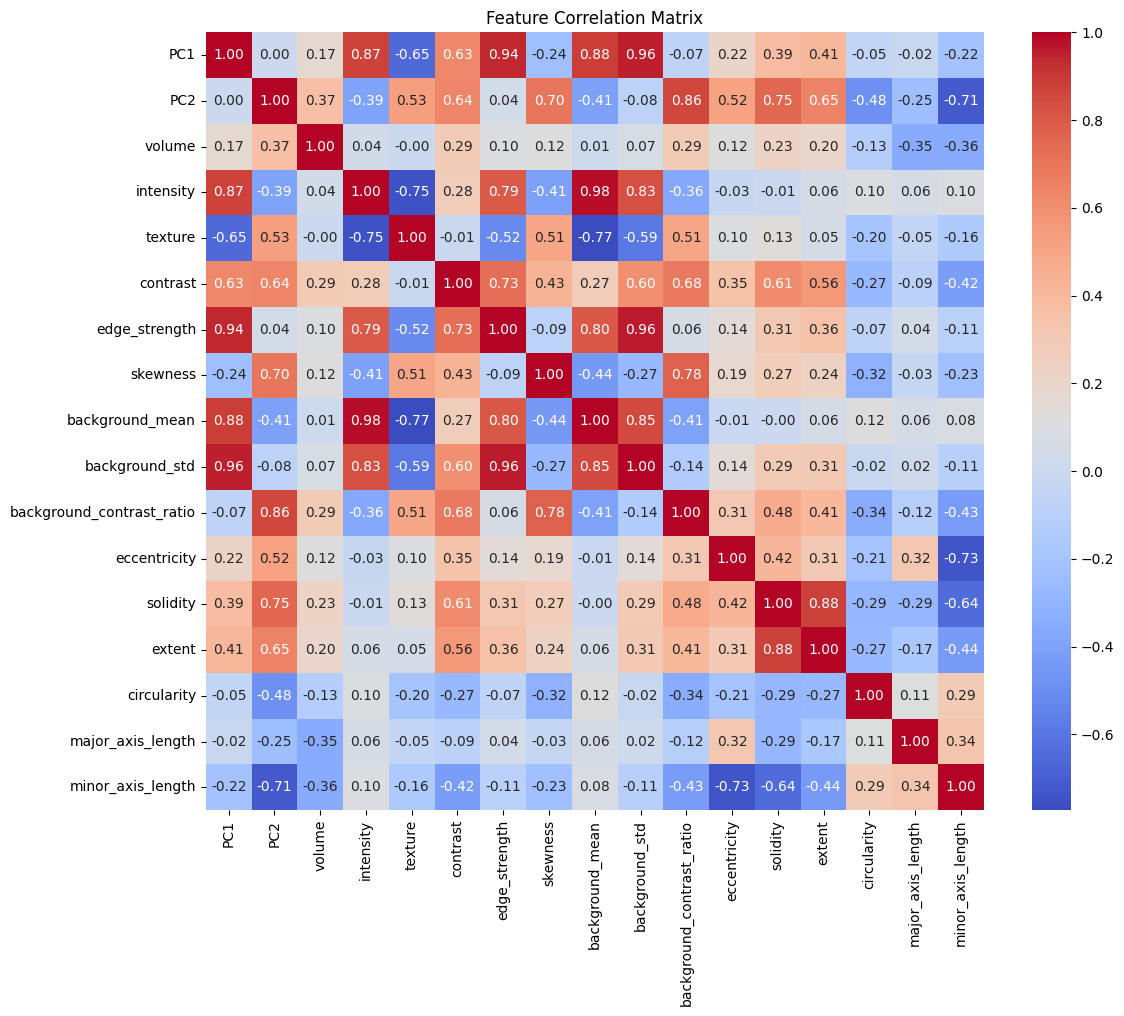

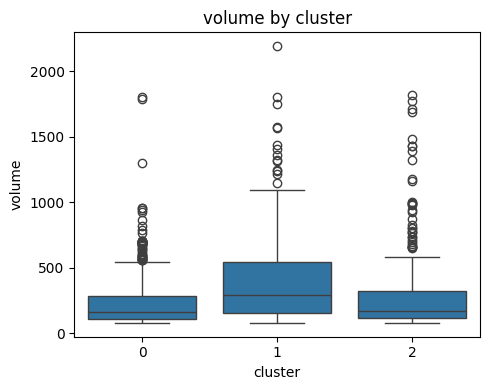

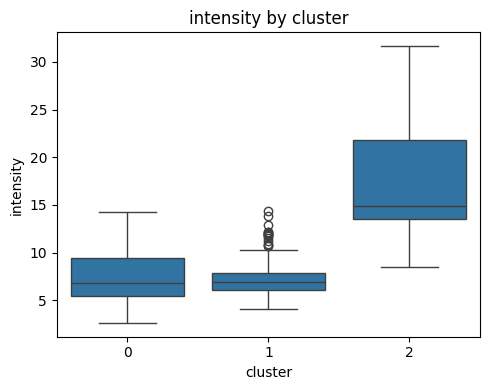

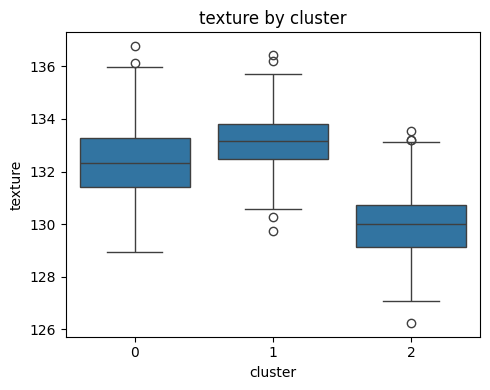

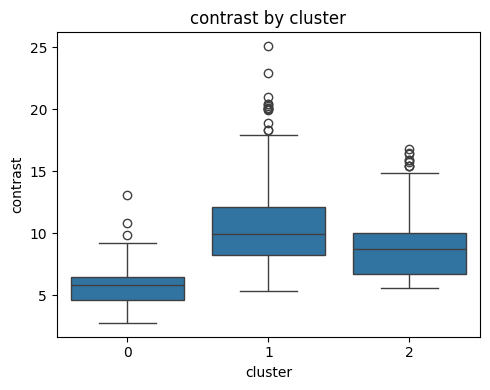

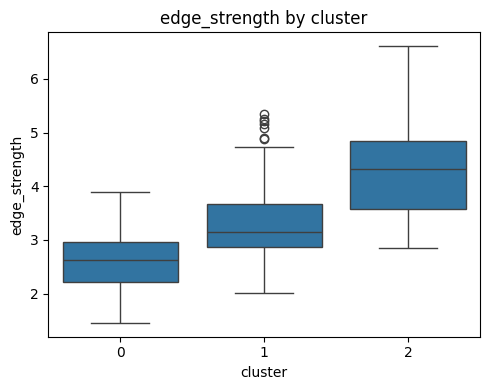

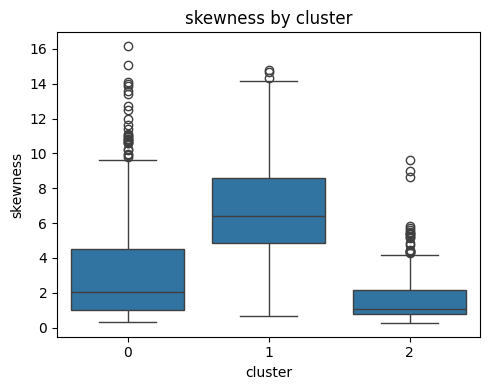

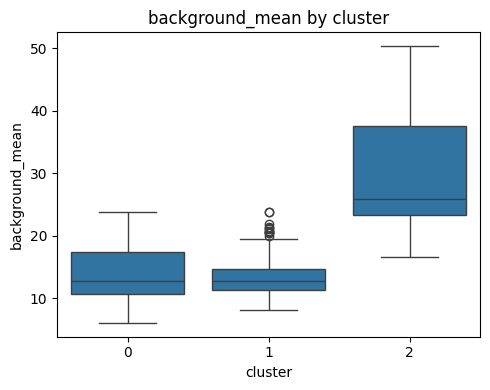

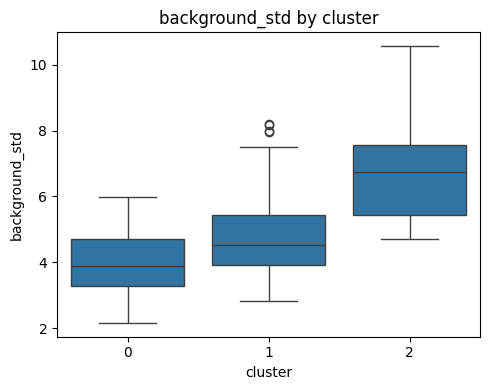

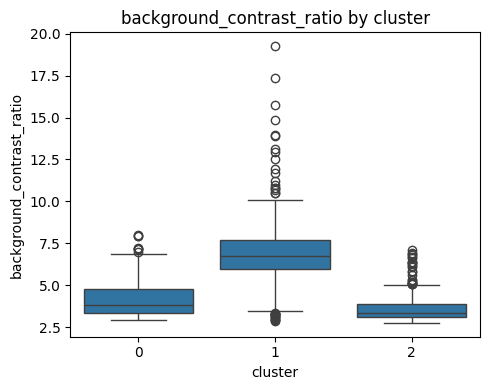

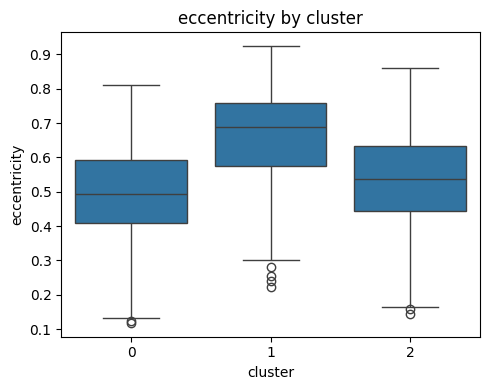

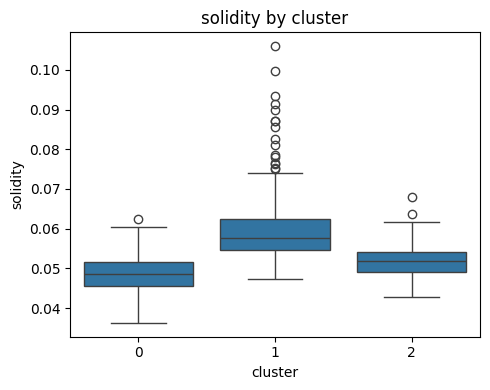

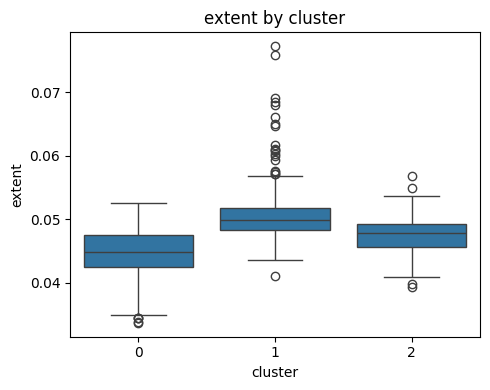

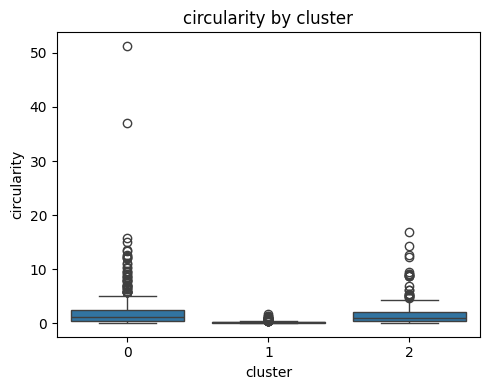

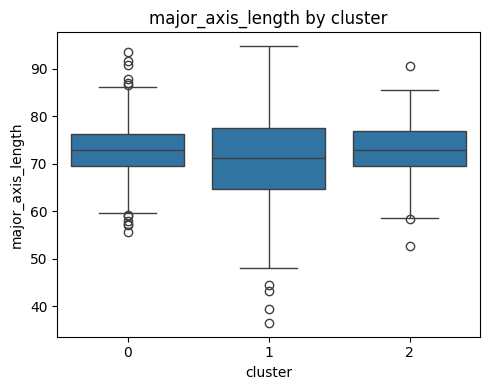

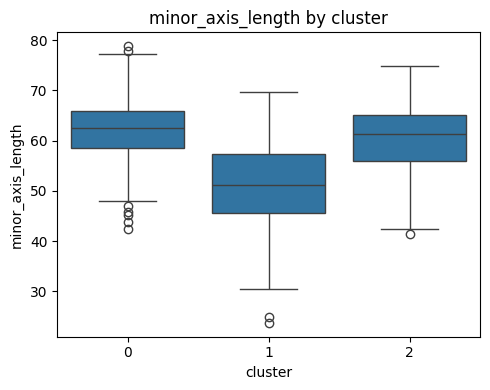

Cluster 0 Examples


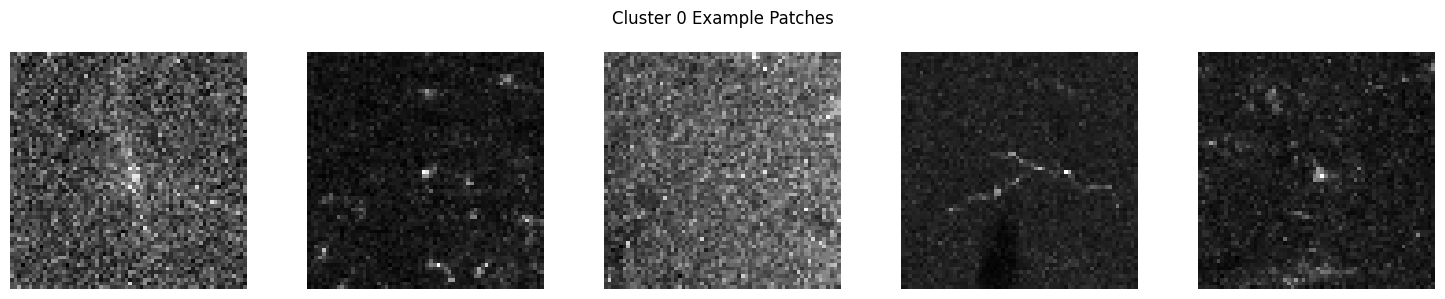

Cluster 1 Examples


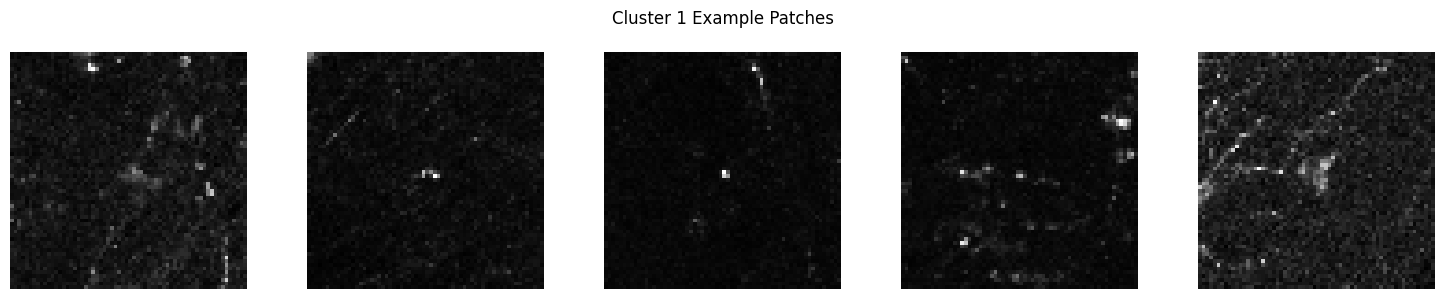

Cluster 2 Examples


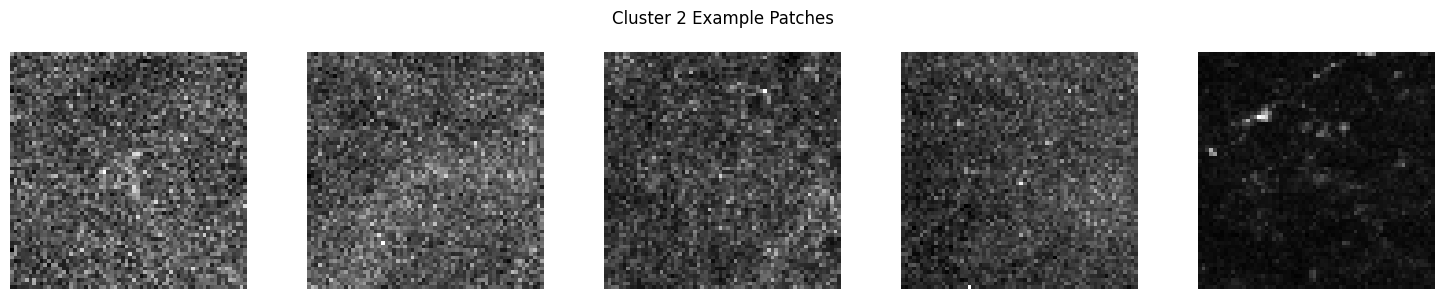

In [72]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell 6: Correlation Matrix, Boxplots, and Example Patches per Cluster
# ─────────────────────────────────────────────────────────────────────────────
import os
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ─── Paths ────────────────────────────────────────────────────────────────────
MODEL_DIR = r"D:\PSM\SST_images\SST3\models"
PATCH_DIR = os.path.join(MODEL_DIR, "patches")
FEATURE_FILE = os.path.join(MODEL_DIR, "radiatum_patch_features.parquet")

# ─── Load feature DataFrame ───────────────────────────────────────────────────
feat_df = pq.read_table(FEATURE_FILE).to_pandas()

# ─── Define full list of features (including PCA columns if present) ─────────
full_features = [
    'PC1', 'PC2',
    'volume', 'intensity', 'texture', 'contrast', 'edge_strength', 'skewness',
    'background_mean', 'background_std', 'background_contrast_ratio',
    'eccentricity', 'solidity', 'extent', 'circularity',
    'major_axis_length', 'minor_axis_length'
]

# ─── Compute & Plot Correlation Matrix ────────────────────────────────────────
corr = feat_df[full_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

# ─── Boxplots of Each Feature by Cluster ─────────────────────────────────────
for feat in full_features[2:]:  # skip PC1, PC2
    plt.figure(figsize=(5, 4))
    sns.boxplot(x='cluster', y=feat, data=feat_df)
    plt.title(f"{feat} by cluster")
    plt.tight_layout()
    plt.show()

# ─── Display Example Patches per Cluster ─────────────────────────────────────
for c in sorted(feat_df['cluster'].unique()):
    print(f"Cluster {c} Examples")
    cluster_samples = feat_df[feat_df.cluster == c].sample(n=5, random_state=42)
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for ax, (_, row) in zip(axes, cluster_samples.iterrows()):
        pid = row['patch_id']
        patch_path = os.path.join(PATCH_DIR, f"{pid}.npy")
        if os.path.exists(patch_path):
            patch = np.load(patch_path)
            mip = patch.max(axis=0)
            ax.imshow(mip, cmap='gray')
        else:
            ax.text(0.5, 0.5, "Missing", ha='center', va='center')
        ax.axis('off')
    plt.suptitle(f'Cluster {c} Example Patches', fontsize=12)
    plt.tight_layout()
    plt.show()


In [141]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell 7: PCA + k-means Sampling for Annotation (Skip Already Annotated)
# ─────────────────────────────────────────────────────────────────────────────
import os
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# ─── Configuration ────────────────────────────────────────────────────────────
MODEL_DIR     = r"D:\PSM\SST_images\SST3\models"
FEATURE_FILE  = os.path.join(MODEL_DIR, "radiatum_patch_features.parquet")
ANNOT_PATH    = os.path.join(MODEL_DIR, "annotated_labels.csv")
OUTPUT_CSV    = os.path.join(MODEL_DIR, "annotation_samples.csv")
N_PER_CLUSTER = 20   # number of examples to sample per cluster
K             = 3    # number of clusters to form

# ─── Load updated features ────────────────────────────────────────────────────
feat_df = pd.read_parquet(FEATURE_FILE)

# ─── Exclude already annotated patches ────────────────────────────────────────
if os.path.exists(ANNOT_PATH):
    annotated_df = pd.read_csv(ANNOT_PATH)
    annotated_ids = set(annotated_df['patch_id'])
    feat_df = feat_df[~feat_df['patch_id'].isin(annotated_ids)].copy()
    print("🔍 Skipping {} already annotated patches.".format(len(annotated_ids)))
else:
    print("📂 No existing annotation file found — all patches included.")

# ─── Select feature columns for clustering ────────────────────────────────────
features = [
    'volume', 'intensity', 'texture', 'contrast', 'edge_strength', 'skewness',
    'background_mean', 'background_std', 'background_contrast_ratio',
    'eccentricity', 'solidity', 'extent', 'circularity',
    'major_axis_length', 'minor_axis_length'
]

# ─── Standardize and PCA-transform ────────────────────────────────────────────
X = StandardScaler().fit_transform(feat_df[features])
pca2 = PCA(n_components=2).fit_transform(X)
feat_df['PC1'], feat_df['PC2'] = pca2[:, 0], pca2[:, 1]

# ─── k-means clustering in PCA space ───────────────────────────────────────────
labels = KMeans(n_clusters=K, random_state=0).fit_predict(pca2)
feat_df['cluster'] = labels

# ─── Save updated .parquet file with cluster labels ───────────────────────────
feat_df.to_parquet(FEATURE_FILE, index=False)

# ─── Sample per cluster for annotation ────────────────────────────────────────
annotation_samples = (
    feat_df
    .groupby('cluster', group_keys=False)
    .apply(lambda g: g.sample(min(len(g), N_PER_CLUSTER), random_state=42))
    .reset_index(drop=True)
)

# ─── Save sampled patch IDs + cluster labels ──────────────────────────────────
annotation_samples[['patch_id', 'cluster']].to_csv(OUTPUT_CSV, index=False)
print(f"✅ Sampled {len(annotation_samples)} patches ({N_PER_CLUSTER}/cluster) →\n  {OUTPUT_CSV}")


🔍 Skipping 480 already annotated patches.
✅ Sampled 60 patches (20/cluster) →
  D:\PSM\SST_images\SST3\models\annotation_samples.csv


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Antho\AppData\Local\Temp\ipykernel_34980\541344284.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(min(len(g), N_PER_CLUSTER), random_state=42))


In [135]:
'''# ─────────────────────────────────────────────────────────────────────────────
# Cell X: De-duplicate patches by content & preserve existing annotations
# ─────────────────────────────────────────────────────────────────────────────
import os, hashlib
import numpy as np
import pandas as pd
import pyarrow.parquet as pq

# ─── Paths ────────────────────────────────────────────────────────────────────
MODEL_DIR     = r"D:\PSM\SST_images\SST3\models"
PATCH_DIR     = os.path.join(MODEL_DIR, "patches")
ANNOT_CSV     = os.path.join(MODEL_DIR, "annotated_labels.csv")
SAMPLES_CSV   = os.path.join(MODEL_DIR, "annotation_samples.csv")
FEATURE_FILE  = os.path.join(MODEL_DIR, "radiatum_patch_features.parquet")

# ─── Load existing annotations (if any) ───────────────────────────────────────
if os.path.exists(ANNOT_CSV):
    ann_df = pd.read_csv(ANNOT_CSV)
    annotated_ids = set(ann_df['patch_id'])
else:
    annotated_ids = set()

# ─── Compute content-hash for each patch ──────────────────────────────────────
hash_map = {}   # hash → [patch_id, ...]
path_map = {}   # patch_id → full file path
for fname in os.listdir(PATCH_DIR):
    if not fname.endswith('.npy'):
        continue
    pid = fname[:-4]
    fpath = os.path.join(PATCH_DIR, fname)
    try:
        arr = np.load(fpath)
    except:
        continue
    h = hashlib.md5(arr.tobytes()).hexdigest()
    hash_map.setdefault(h, []).append(pid)
    path_map[pid] = fpath

# ─── For each group of identical-content patches, pick a canonical ID ─────────
id_map = {}  # old_id → canonical_id
for h, pids in hash_map.items():
    if len(pids) == 1:
        continue

    # 1) If any in this group is annotated, pick that as canonical
    annotated_in_group = [pid for pid in pids if pid in annotated_ids]
    if annotated_in_group:
        canonical = annotated_in_group[0]
    else:
        # 2) Otherwise pick the one with the latest modification time
        mtimes = [(pid, os.path.getmtime(path_map[pid])) for pid in pids]
        canonical = max(mtimes, key=lambda x: x[1])[0]

    # 3) All others become duplicates → delete file & record mapping
    for pid in pids:
        if pid == canonical:
            continue
        id_map[pid] = canonical
        try:
            os.remove(path_map[pid])
        except Exception:
            print(f"❌ Failed to delete {pid}.npy")
        else:
            print(f"🗑️  Deleted duplicate patch {pid}.npy (keeping {canonical}.npy)")

# ─── If any duplicates were found, update annotation CSV ───────────────────────
if id_map and os.path.exists(ANNOT_CSV):
    ann_df = pd.read_csv(ANNOT_CSV)
    # map old IDs to canonical, then drop duplicate rows
    ann_df['patch_id'] = ann_df['patch_id'].map(lambda pid: id_map.get(pid, pid))
    ann_df = ann_df.drop_duplicates(subset='patch_id', keep='last')
    ann_df.to_csv(ANNOT_CSV, index=False)
    print(f"✅ Updated annotations → {ANNOT_CSV}")

# ─── Also update the sampling list (if it exists) ─────────────────────────────
if id_map and os.path.exists(SAMPLES_CSV):
    samp_df = pd.read_csv(SAMPLES_CSV)
    samp_df['patch_id'] = samp_df['patch_id'].map(lambda pid: id_map.get(pid, pid))
    samp_df = samp_df.drop_duplicates(subset='patch_id', keep='last')
    samp_df.to_csv(SAMPLES_CSV, index=False)
    print(f"✅ Updated sampling list → {SAMPLES_CSV}")

# ─── Finally, update the feature table to point to canonical IDs ──────────────
if id_map and os.path.exists(FEATURE_FILE):
    ft = pq.read_table(FEATURE_FILE).to_pandas()
    ft['patch_id'] = ft['patch_id'].map(lambda pid: id_map.get(pid, pid))
    ft = ft.drop_duplicates(subset=['patch_id'], keep='last')
    ft.to_parquet(FEATURE_FILE, index=False)
    print(f"✅ Updated feature table → {FEATURE_FILE}")

# ─── Summary ─────────────────────────────────────────────────────────────────
if not id_map:
    print("ℹ️  No duplicate patches found—nothing to update.")
else:
    print(f"✅ Completed de-duplication. {len(id_map)} patches remapped.")


SyntaxError: incomplete input (3448596709.py, line 1)

In [142]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell 8: Interactive Annotation Widget
# ─────────────────────────────────────────────────────────────────────────────
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import BoundedIntText, IntSlider, Button, Output, VBox, HBox
from skimage.filters import gaussian

# ─── Configuration ────────────────────────────────────────────────────────────
MODEL_DIR   = r"D:\PSM\SST_images\SST3\models"
PATCH_DIR   = os.path.join(MODEL_DIR, "patches")
SAMPLES_CSV = os.path.join(MODEL_DIR, "annotation_samples.csv")
ANNOT_CSV   = os.path.join(MODEL_DIR, "annotated_labels.csv")

# ─── Load sample list and filter out already-labeled patches ──────────────────
full_df = pd.read_csv(SAMPLES_CSV)
if os.path.exists(ANNOT_CSV):
    existing = pd.read_csv(ANNOT_CSV)
    done_ids = set(existing['patch_id'])
    annotation_df = full_df[~full_df['patch_id'].isin(done_ids)].reset_index(drop=True)
else:
    annotation_df = full_df.copy()

if annotation_df.empty:
    raise ValueError("✅ All patches already annotated!")

# ─── Widgets ─────────────────────────────────────────────────────────────────
idx_widget  = BoundedIntText(value=0, min=0, max=len(annotation_df)-1, description='Index')
vmin_slider = IntSlider(min=0, max=255, value=0, description='Min LUT')
vmax_slider = IntSlider(min=0, max=255, value=255, description='Max LUT')
prev_btn    = Button(description='◀ Prev')
next_btn    = Button(description='Next ▶')
cell_btn    = Button(description='Label ▶ Cell', button_style='success')
junk_btn    = Button(description='Label ▶ Junk', button_style='danger')
save_btn    = Button(description='💾 Finish & Save', button_style='info')
output      = Output()

annotations = []

# ─── Helper functions ─────────────────────────────────────────────────────────
def load_patch(idx):
    pid  = annotation_df.iloc[idx]['patch_id']
    path = os.path.join(PATCH_DIR, pid + ".npy")
    if not os.path.exists(path):
        return None, pid
    patch = np.load(path)
    return patch.max(axis=0), pid

def redraw(*args):
    output.clear_output(wait=True)
    with output:
        mip, pid = load_patch(idx_widget.value)
        if mip is None:
            print(f"❌ Missing patch: {pid}")
            return
        smooth = gaussian(mip, sigma=1)
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        for ax, img, title in zip(axs, [mip, smooth], ['Original', 'Smoothed']):
            ax.imshow(img, cmap='gray', vmin=vmin_slider.value, vmax=vmax_slider.value)
            ax.set_title(title, fontsize=10)
            ax.axis('off')
        plt.suptitle(pid, fontsize=8)
        plt.show()

def step(delta):
    idx_widget.value = max(idx_widget.min, min(idx_widget.max, idx_widget.value + delta))

def label_and_next(label):
    pid = annotation_df.iloc[idx_widget.value]['patch_id']
    annotations.append({'patch_id': pid, 'label': label})
    print(f"✅ Labeled {'Cell' if label else 'Junk'} → {pid}")
    step(1)

def on_prev(b): step(-1)
def on_next(b): step(1)
def on_cell(b): label_and_next(1)
def on_junk(b): label_and_next(0)

def on_save(b):
    if not annotations:
        print("⚠️ No annotations to save.")
        return
    new_df = pd.DataFrame(annotations)
    if os.path.exists(ANNOT_CSV):
        old_df = pd.read_csv(ANNOT_CSV)
        combined = pd.concat([old_df, new_df], ignore_index=True)
        combined = combined.drop_duplicates(subset='patch_id', keep='last')
    else:
        combined = new_df
    combined.to_csv(ANNOT_CSV, index=False)
    print(f"✅ Saved annotations → {ANNOT_CSV}")

# ─── Wire up events ───────────────────────────────────────────────────────────
prev_btn.on_click(on_prev)
next_btn.on_click(on_next)
cell_btn.on_click(on_cell)
junk_btn.on_click(on_junk)
save_btn.on_click(on_save)
for w in (idx_widget, vmin_slider, vmax_slider):
    w.observe(lambda e: redraw(), names='value')

# ─── Display UI ───────────────────────────────────────────────────────────────
nav = HBox([prev_btn, idx_widget, next_btn, vmin_slider, vmax_slider])
lbl = HBox([cell_btn, junk_btn, save_btn])
display(VBox([nav, lbl, output]))
redraw()


In [49]:
'''# Load current feature table
feat_df = pd.read_parquet(FEATURE_FILE)
valid_ids = set(feat_df['patch_id'])

# Load annotations
annot_df = pd.read_csv(ANNOT_PATH)
annot_valid = annot_df[annot_df['patch_id'].isin(valid_ids)].copy()
annot_quarantine = annot_df[~annot_df['patch_id'].isin(valid_ids)].copy()

# Save filtered main file + quarantine
annot_valid.to_csv(ANNOT_PATH, index=False)
quarantine_path = ANNOT_PATH.replace(".csv", "_quarantine_missing.csv")
annot_quarantine.to_csv(quarantine_path, index=False)

print("✅ Updated annotations: {} valid, {} quarantined.".format(
    len(annot_valid), len(annot_quarantine)))
print("💾 Saved to:\n  Main → {}\n  Quarantine → {}".format(ANNOT_PATH, quarantine_path))


✅ Updated annotations: 0 valid, 540 quarantined.
💾 Saved to:
  Main → D:\PSM\SST_images\SST3\models\annotated_labels.csv
  Quarantine → D:\PSM\SST_images\SST3\models\annotated_labels_quarantine_missing.csv


In [144]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell 9: Augment Annotated Patches & Extract Features (with combination)
# ─────────────────────────────────────────────────────────────────────────────
import os
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from skimage.feature import local_binary_pattern
from skimage.transform import rotate
from scipy.ndimage import binary_fill_holes
from skimage.morphology import binary_dilation, disk
from skimage.measure import regionprops

# ─── Configuration ────────────────────────────────────────────────────────────
MODEL_DIR      = r"D:\PSM\SST_images\SST3\models"
PATCH_DIR      = os.path.join(MODEL_DIR, "patches")
ANNOT_CSV      = os.path.join(MODEL_DIR, "annotated_labels.csv")
AUG_FEATURES   = os.path.join(MODEL_DIR, "radiatum_patch_features_augmented.parquet")
COMBINED_FEATURES = os.path.join(MODEL_DIR, "radiatum_patch_features_combined.parquet")
ORIG_FEATURES  = os.path.join(MODEL_DIR, "radiatum_patch_features.parquet")
PATCH_PADDING  = 4   # must match the value used during original feature extraction
LBP_P          = 8
LBP_R          = 1

# ─── Ensure output directory exists ───────────────────────────────────────────
os.makedirs(PATCH_DIR, exist_ok=True)
# ------------------------------------------------------------------
# Auto-extract features for any annotated patch not yet in orig_feats
missing_ids = [pid for pid in ann_df['patch_id'] if pid not in orig_feats.index]

if missing_ids:
    from tqdm import tqdm
    new_recs = []            # reuse extract_* + process_object helpers
    for pid in tqdm(missing_ids, desc="⇢ extracting missing features"):
        # derive base_id, obj_idx from pid, then load .npy and compute
        # shape/background/intensity/etc.  Append to new_recs
        pass                # <-- reuse your logic from process_object
    if new_recs:
        orig_feats = pd.concat([orig_feats, pd.DataFrame(new_recs)], ignore_index=True)
# ------------------------------------------------------------------

# ─── Helper Functions (reuse from Cell 4) ─────────────────────────────────────
def extract_shape_features(mask):
    props = regionprops(mask.astype(int))
    if not props:
        return {
            "eccentricity": np.nan,
            "solidity": np.nan,
            "extent": np.nan,
            "circularity": np.nan,
            "major_axis_length": np.nan,
            "minor_axis_length": np.nan
        }
    p = props[0]
    circ = (4 * np.pi * p.area) / (p.perimeter ** 2) if p.perimeter else 0
    return {
        "eccentricity": p.eccentricity,
        "solidity": p.solidity,
        "extent": p.extent,
        "circularity": circ,
        "major_axis_length": p.major_axis_length,
        "minor_axis_length": p.minor_axis_length,
    }

def extract_background_features(mip, binary_mask):
    dilated = binary_dilation(binary_mask, disk(PATCH_PADDING))
    background_mask = np.logical_and(dilated, ~binary_mask)
    background_vals = mip[background_mask]
    if background_vals.size == 0:
        return {"background_mean": 0, "background_std": 1, "background_contrast_ratio": 0}
    bg_mean = background_vals.mean()
    bg_std = background_vals.std() if background_vals.std() > 0 else 1
    obj_mean = mip[binary_mask].mean()
    return {
        "background_mean": bg_mean,
        "background_std": bg_std,
        "background_contrast_ratio": (obj_mean - bg_mean) / bg_std
    }

# ─── Load annotations & original feature table ───────────────────────────────
ann_df = pd.read_csv(ANNOT_CSV)  # contains 'patch_id' and 'label'
orig_feats = pq.read_table(ORIG_FEATURES).to_pandas().set_index("patch_id", drop=False)

# ─── Prepare list to collect augmented records ────────────────────────────────
augmented_records = []

for _, row in ann_df.iterrows():
    pid = row["patch_id"]
    label = row["label"]
    if pid not in orig_feats.index:
        print(f"❌ Skipping {pid}: not found in feature table")
        continue

    # Retrieve original metadata
    meta = orig_feats.loc[pid]
    volume = meta["volume"]
    base_id = meta.get("base_id", "")
    obj_idx = meta.get("obj_idx", np.nan)

    # Load the raw 3D patch
    patch_path = os.path.join(PATCH_DIR, pid + ".npy")
    if not os.path.exists(patch_path):
        print(f"❌ Missing patch file: {pid}")
        continue
    patch_3d = np.load(patch_path)

    # Compute the max‐projection and binary mask once
    mip_orig = patch_3d.max(axis=0)
    mask_orig = binary_fill_holes(mip_orig > np.percentile(mip_orig, 95))

    # Define augmentations: rotation ±90°, flips H/V
    transforms = {
        "rot90"   : lambda p: rotate(p,  90, preserve_range=True).astype(np.uint8),
        "rot270"  : lambda p: rotate(p, -90, preserve_range=True).astype(np.uint8),
        "flip_h"  : lambda p: np.flip(p, axis=2).astype(np.uint8),  # flip along X
        "flip_v"  : lambda p: np.flip(p, axis=1).astype(np.uint8),  # flip along Y
    }

    for aug_name, func in transforms.items():
        aug_3d = func(patch_3d)
        new_pid = f"{pid}_{aug_name}"
        aug_path = os.path.join(PATCH_DIR, new_pid + ".npy")

        # Skip if we've already created this augmentation before
        if not os.path.exists(aug_path):
            np.save(aug_path, aug_3d, allow_pickle=False)

        # Compute augmented features
        mip = aug_3d.max(axis=0)
        mask = binary_fill_holes(mip > np.percentile(mip, 95))

        shape_feats = extract_shape_features(mask)
        bg_feats = extract_background_features(mip, mask)

        intensity = aug_3d.mean()
        texture = local_binary_pattern(mip, P=LBP_P, R=LBP_R).mean()
        contrast = mip.std()
        edge_strength = np.mean(np.abs(np.gradient(mip.astype(float))))
        skewness = ((mip - mip.mean())**3).mean() / (mip.std()**3 + 1e-5)

        rec = {
            "patch_id": new_pid,
            "base_id": base_id,
            "obj_idx": obj_idx,
            "volume": volume,
            "intensity": intensity,
            "texture": texture,
            "contrast": contrast,
            "edge_strength": edge_strength,
            "skewness": skewness,
            **shape_feats,
            **bg_feats,
            "label": label
        }
        augmented_records.append(rec)

# ─── Convert augmented records to DataFrame & save to Parquet ────────────────
aug_df = pd.DataFrame(augmented_records)
if not aug_df.empty:
    pq.write_table(pa.Table.from_pandas(aug_df), AUG_FEATURES)
    print(f"✅ Saved {len(aug_df)} augmented feature rows → {AUG_FEATURES}")
else:
    print("⚠️ No augmentations were generated (check that annotated patches exist).")

# ─── Combine original labeled + augmented rows ─────────────────────────────────
# Load only those original rows that have labels
orig_labeled = orig_feats.loc[orig_feats["patch_id"].isin(ann_df["patch_id"])].copy()

# Concatenate
combined_df = pd.concat([orig_labeled, aug_df], ignore_index=True)

# Save combined dataset
combined_df.to_parquet(COMBINED_FEATURES, index=False)
print(f"✅ Combined original + augmented saved → {COMBINED_FEATURES}")


✅ Saved 2160 augmented feature rows → D:\PSM\SST_images\SST3\models\radiatum_patch_features_augmented.parquet
✅ Combined original + augmented saved → D:\PSM\SST_images\SST3\models\radiatum_patch_features_combined.parquet


              precision    recall  f1-score   support

        Junk       0.81      0.96      0.88       410
        Cell       0.71      0.28      0.41       130

    accuracy                           0.80       540
   macro avg       0.76      0.62      0.64       540
weighted avg       0.79      0.80      0.77       540

Confusion matrix:
 [[395  15]
 [ 93  37]]
ROC AUC: 0.799
5-fold CV AUC: 0.947±0.029
✅ Saved model to D:\PSM\SST_images\SST3\models\rf_radiatum_classifier.pkl

🔍 Feature Importances (highest to lowest):

 1. volume                    0.1480
 2. background_contrast_ratio 0.0912
 3. background_std            0.0826
 4. skewness                  0.0822
 5. circularity               0.0643
 6. edge_strength             0.0618
 7. intensity                 0.0605
 8. background_mean           0.0591
 9. extent                    0.0562
10. major_axis_length         0.0562
11. solidity                  0.0560
12. minor_axis_length         0.0543
13. contrast              

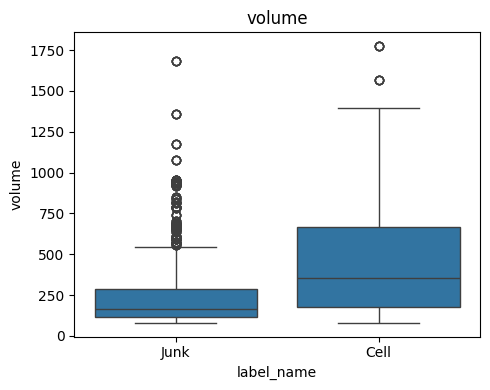

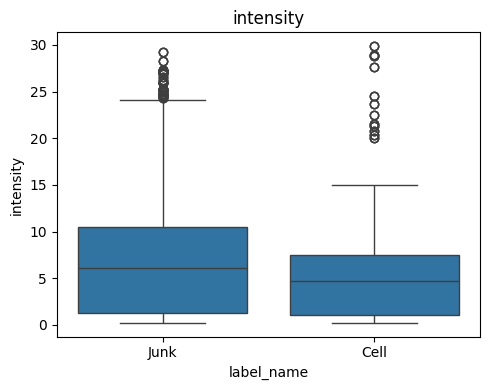

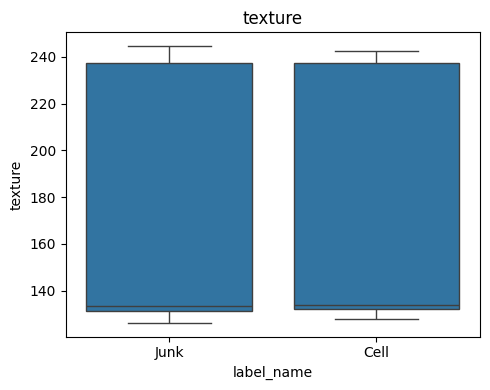

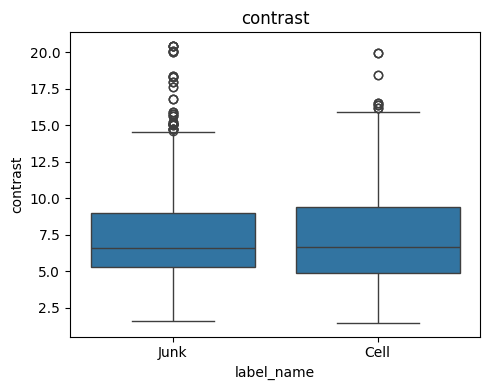

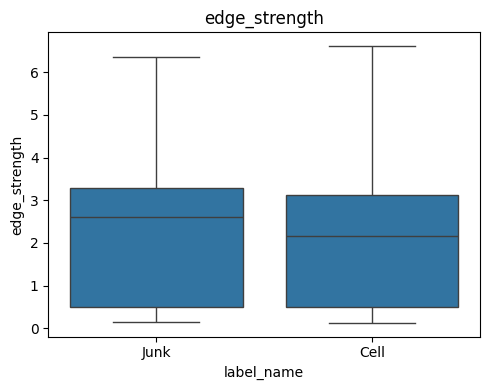

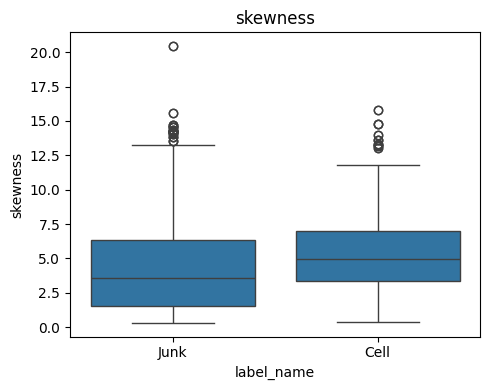

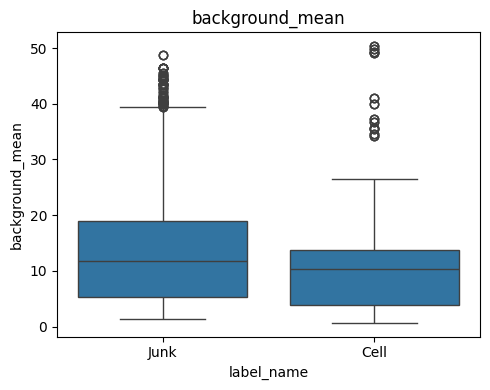

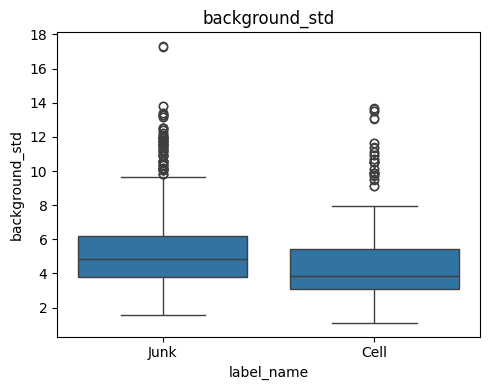

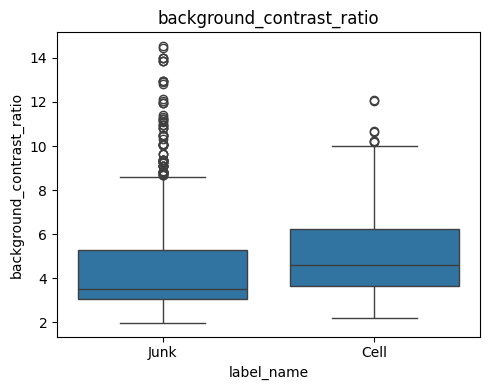

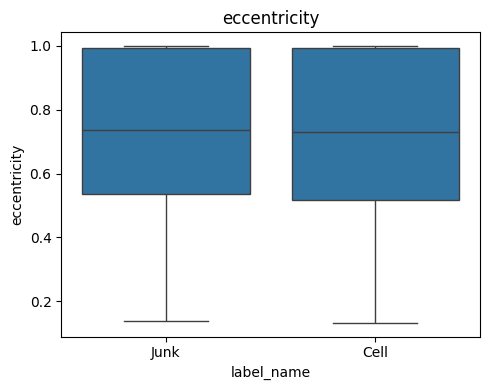

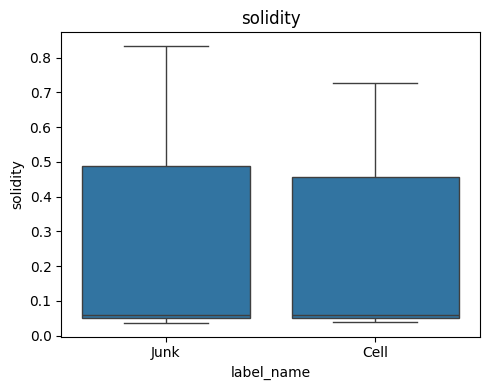

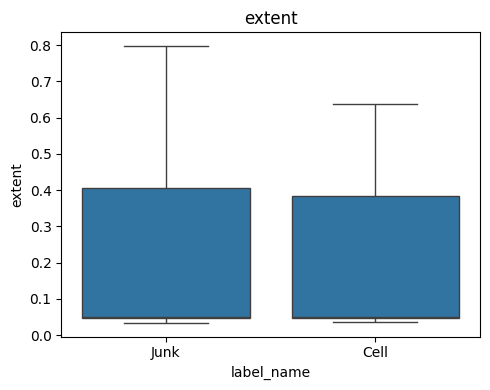

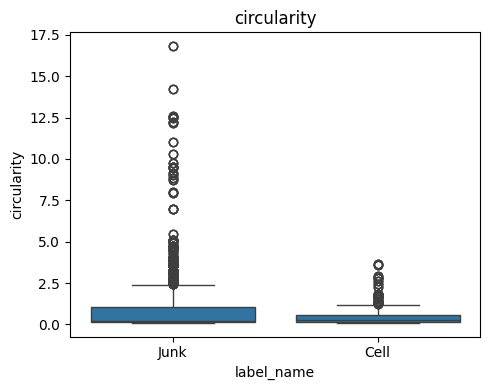

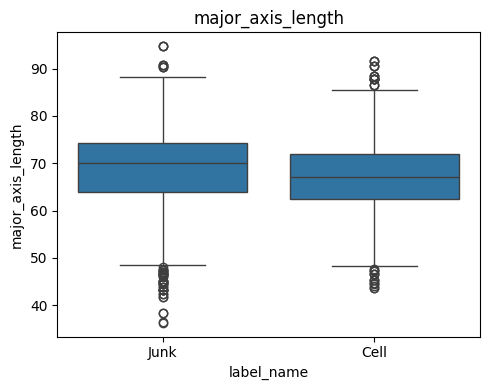

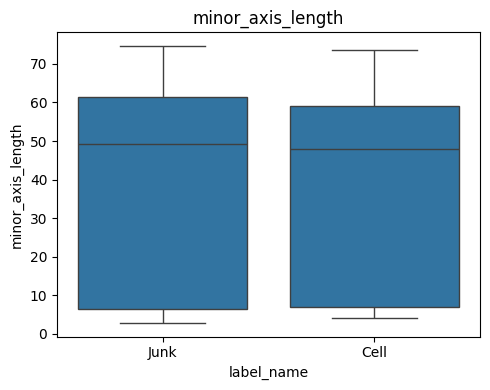

In [145]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell 10: Train RandomForest & Print Feature Importances + Boxplots by Label
# ─────────────────────────────────────────────────────────────────────────────
import os
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# ─── Configuration ────────────────────────────────────────────────────────────
MODEL_DIR      = r"D:\PSM\SST_images\SST3\models"
FEATURE_FILE   = os.path.join(MODEL_DIR, "radiatum_patch_features_combined.parquet")
ANNOT_CSV      = os.path.join(MODEL_DIR, "annotated_labels.csv")
OUTPUT_MODEL   = os.path.join(MODEL_DIR, "rf_radiatum_classifier.pkl")

# ─── Load & Merge Features with Labels ────────────────────────────────────────
features_df = pd.read_parquet(FEATURE_FILE)
annotations = pd.read_csv(ANNOT_CSV)

# Assign labels to original (non-augmented) data
orig_labeled = features_df[features_df['patch_id'].isin(annotations['patch_id'])].copy()
orig_labeled = orig_labeled.merge(annotations[['patch_id', 'label']], on='patch_id', how='left')

# Augmented rows already have label
augmented_rows = features_df[~features_df['patch_id'].isin(orig_labeled['patch_id'])].copy()

# Combine both
df = pd.concat([orig_labeled, augmented_rows], ignore_index=True)

# Create a mapping from original patch_id to label
label_map = dict(zip(annotations['patch_id'], annotations['label']))

# Assign label to all rows based on their base (non-augmented) patch ID
df['base_patch'] = df['patch_id'].str.extract(r'(PSM_[A-Z]_CA1_10x_\d+_\d+)')
df['label'] = df['base_patch'].map(label_map)
df.drop(columns=['base_patch'], inplace=True)


# Filter out rows without a valid label
initial_count = len(df)
df = df[df['label'].notna()].copy()
removed_count = initial_count - len(df)
if removed_count > 0:
    print("⚠️ Dropped {} rows without valid labels.".format(removed_count))

# ─── Define feature columns ────────────────────────────────────────────────────
feature_cols = [
    'volume', 'intensity', 'texture', 'contrast', 'edge_strength', 'skewness',
    'background_mean', 'background_std', 'background_contrast_ratio',
    'eccentricity', 'solidity', 'extent', 'circularity',
    'major_axis_length', 'minor_axis_length'
]

X = df[feature_cols].values
y = df['label'].astype(int).values  # Ensure integer labels for classifier

# ─── Train-test split ─────────────────────────────────────────────────────────
from sklearn.model_selection import GroupShuffleSplit

# Extract base IDs for grouping (e.g., drop "_aug1", "_flipV", etc.)
df['group'] = df['patch_id'].str.extract(r'(PSM_[A-Z]_CA1_10x_\d+_\d+)')

# Split by group
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df, groups=df['group']))

train_df = df.iloc[train_idx]
test_df = df.iloc[test_idx]

X_train = train_df[feature_cols].values
y_train = train_df['label'].astype(int).values
X_test = test_df[feature_cols].values
y_test = test_df['label'].astype(int).values

# ─── Train RandomForest ───────────────────────────────────────────────────────
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# ─── Evaluate on held-out test set ────────────────────────────────────────────
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, target_names=['Junk', 'Cell']))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.3f}")

# ─── 5-fold Cross-Validation AUC ───────────────────────────────────────────────
cv_scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
print(f"5-fold CV AUC: {cv_scores.mean():.3f}±{cv_scores.std():.3f}")

# ─── Save trained model ───────────────────────────────────────────────────────
with open(OUTPUT_MODEL, "wb") as f:
    pickle.dump(clf, f)
print(f"✅ Saved model to {OUTPUT_MODEL}")

# ─── Print Feature Importances (ranked) ───────────────────────────────────────
feat_importance = pd.Series(clf.feature_importances_, index=feature_cols)
feat_importance = feat_importance.sort_values(ascending=False)

print("\n🔍 Feature Importances (highest to lowest):\n")
for i, (feat, score) in enumerate(feat_importance.items(), 1):
    print(f"{i:>2}. {feat:<25} {score:.4f}")

# ─── Boxplots of Each Feature by Label ────────────────────────────────────────
df['label_name'] = df['label'].map({0: 'Junk', 1: 'Cell'})
for col in feature_cols:
    plt.figure(figsize=(5, 4))
    sns.boxplot(data=df, x='label_name', y=col)
    plt.title(col)
    plt.tight_layout()
    plt.show()


In [148]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell 11 (updated): Auto‐threshold by empirical precision 
#                   → bucket entire labeled set into {Junk, Cell, Uncertain}
# ─────────────────────────────────────────────────────────────────────────────
import os
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score
from sklearn.model_selection import GroupShuffleSplit
import pickle

# ─── Paths ────────────────────────────────────────────────────────────────────
MODEL_DIR      = r"D:\PSM\SST_images\SST3\models"
PATCH_DIR      = os.path.join(MODEL_DIR, "patches")
FEATURE_FILE   = os.path.join(MODEL_DIR, "radiatum_patch_features_combined.parquet")
ANNOT_CSV      = os.path.join(MODEL_DIR, "annotated_labels.csv")
MODEL_PKL      = os.path.join(MODEL_DIR, "rf_radiatum_classifier.pkl")
UNCERTAIN_CSV  = os.path.join(MODEL_DIR, "uncertain_samples.csv")

# ─── Load trained classifier ───────────────────────────────────────────────────
with open(MODEL_PKL, "rb") as f:
    clf = pickle.load(f)

# ─── Load all features and all annotations ─────────────────────────────────────
features_df = pd.read_parquet(FEATURE_FILE)
ann         = pd.read_csv(ANNOT_CSV)

# ─── Merge on patch_id, ensure a single ’label’ column ─────────────────────────
merged = features_df.merge(ann[['patch_id', 'label']], on="patch_id", how="inner")

# If pandas created both label_x and label_y, drop the unlabeled one
if 'label_x' in merged.columns and 'label_y' in merged.columns:
    # keep ’label_y’ (the annotation) and drop ’label_x’
    merged = merged.rename(columns={'label_y': 'label'})
    merged.drop(columns=['label_x'], inplace=True)
elif 'label' not in merged.columns:
    raise ValueError("❌ After merging, no ‘label’ column was found.")
merged['label'] = merged['label'].astype(int)

# ─── Define feature columns ───────────────────────────────────────────────────
feature_cols = [
    'volume', 'intensity', 'texture', 'contrast', 'edge_strength', 'skewness',
    'background_mean', 'background_std', 'background_contrast_ratio',
    'eccentricity', 'solidity', 'extent', 'circularity',
    'major_axis_length', 'minor_axis_length'
]

# ─── Split off a small hold‐out (20%) purely for threshold‐finding ─────────────
merged['group'] = merged['patch_id'].str.extract(r'(PSM_[A-Z]_CA1_10x_\d+_\d+)')
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(merged, groups=merged['group']))
test_df = merged.iloc[test_idx].reset_index(drop=True)

X_test = test_df[feature_cols].values
y_test = test_df['label'].values
y_prob_test = clf.predict_proba(X_test)[:, 1]  # prob(Cell)

# ─── Helper to pick threshold achieving ≥95% precision in held‐out ────────────
def best_threshold(probs, true, target_prec=0.95, side='high', step=0.01):
    """
    side='high': search for t so that when pred Cell iff prob ≥ t,
                  precision(true=1 & pred=1) ≥ target_prec.
    side='low' : search for t so that when pred Junk iff prob ≤ t,
                  precision(true=0 & pred=0) ≥ target_prec.
    """
    if side == 'high':
        thresholds = np.arange(0.99, 0.49, -step)
    else:
        thresholds = np.arange(0.01, 0.51, step)

    for t in thresholds:
        if side == 'high':
            mask = (probs >= t)
            if mask.sum() == 0:
                continue
            preds = np.zeros_like(true)
            preds[mask] = 1
            prec = precision_score(true[mask], preds[mask], zero_division=0)
        else:
            mask = (probs <= t)
            if mask.sum() == 0:
                continue
            preds = np.ones_like(true)
            preds[mask] = 0
            prec = precision_score(true[mask], preds[mask], zero_division=0)
        if prec >= target_prec:
            return t
    return None

high_t = best_threshold(y_prob_test, y_test, target_prec=0.95, side='high')
low_t  = best_threshold(y_prob_test, y_test, target_prec=0.95, side='low')

# Fallback defaults if 95% precision not attained
if high_t is None:
    high_t = 0.80
if low_t is None:
    low_t = 0.20

print(f"📏 Suggested thresholds  →  Cell ≥ {high_t:.2f}   |   Junk ≤ {low_t:.2f}")

# ─── Now bucket ALL labeled patches (not just test) by those cutoffs ─────────
full_probs = clf.predict_proba(merged[feature_cols].values)[:, 1]
merged['prob_cell'] = full_probs

# bucket = 1 if confident Cell, 0 if confident Junk, -1 if uncertain
merged['bucket'] = -1
merged.loc[ full_probs >= high_t, 'bucket'] = 1
merged.loc[ full_probs <= low_t,  'bucket'] = 0

conf_junk  = merged[merged['bucket'] == 0]
conf_cell  = merged[merged['bucket'] == 1]
uncertain  = merged[merged['bucket'] == -1]

print(f"✅ Confident Junk  (bucket=0): {len(conf_junk)}")
print(f"✅ Confident Cell  (bucket=1): {len(conf_cell)}")
print(f"❓ Uncertain       (bucket=-1): {len(uncertain)}")

# ─── Save “uncertain” list for the next annotation widget ───────────────────────
if len(uncertain) > 0:
    uncertain[['patch_id','prob_cell']].to_csv(UNCERTAIN_CSV, index=False)
    print(f"💾 ‘uncertain’ list →  {UNCERTAIN_CSV}")
else:
    print("🎉 No uncertain patches at current thresholds.")


📏 Suggested thresholds  →  Cell ≥ 0.94   |   Junk ≤ 0.20
✅ Confident Junk  (bucket=0): 399
✅ Confident Cell  (bucket=1): 73
❓ Uncertain       (bucket=-1): 68
💾 ‘uncertain’ list →  D:\PSM\SST_images\SST3\models\uncertain_samples.csv


In [11]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell 12: Find “uncertain” among the remaining (original, unannotated) patches
# ─────────────────────────────────────────────────────────────────────────────
import pandas as pd
import pickle
import numpy as np

# ─── Configuration ────────────────────────────────────────────────────────────
ANNOT_CSV     = r"D:\PSM\SST_images\SST3\models\annotated_labels.csv"
FEATURE_FILE  = r"D:\PSM\SST_images\SST3\models\radiatum_patch_features_combined.parquet"
MODEL_PATH    = r"D:\PSM\SST_images\SST3\models\rf_radiatum_classifier.pkl"
OUT_CSV       = r"D:\PSM\SST_images\SST3\models\uncertain_unannotated.csv"

# ─── Load the trained classifier ───────────────────────────────────────────────
with open(MODEL_PATH, "rb") as f:
    clf = pickle.load(f)

# ─── Load the full (combined) feature table ────────────────────────────────────
df = pd.read_parquet(FEATURE_FILE)

# ─── Filter out any augmented patches (they have suffixes like “_rot…”, “_flip…”, etc.) ────────────
#     We assume any patch_id containing “_rot” or “_flip” was created during augmentation.
mask_aug = df["patch_id"].str.contains(r"_(rot|flip)", regex=True)
df = df[~mask_aug].copy()

# ─── Remove patches that have already been annotated ───────────────────────────────
annotated_ids = set(pd.read_csv(ANNOT_CSV)["patch_id"])
df = df[~df["patch_id"].isin(annotated_ids)].copy()

print("ℹ️  Total unannotated, original patches:", len(df))

# ─── If there are no such patches left, bail out gracefully ─────────────────────────
if len(df) == 0:
    print("⚠️ No unannotated, non‐augmented patches remain. Skipping prediction.")
else:
    # ─── Feature columns must match exactly what the model was trained on ────────────
    feature_cols = [
        "volume", "intensity", "texture", "contrast", "edge_strength", "skewness",
        "background_mean", "background_std", "background_contrast_ratio",
        "eccentricity", "solidity", "extent", "circularity",
        "major_axis_length", "minor_axis_length"
    ]

    # ─── Extract feature matrix and run predict_proba ────────────────────────────────
    X = df[feature_cols].values
    prob_cell = clf.predict_proba(X)[:, 1]
    df["prob_cell"] = prob_cell
    df["pred"] = (df["prob_cell"] >= 0.5).astype(int)

    # ─── Decide your “confident” thresholds (these were suggested by Cell 11) ───────────
    THRESH_CELL = 0.94
    THRESH_JUNK = 0.20

    #   bucket = 1 ⇒ “confidently Cell”
    #   bucket = 0 ⇒ “confidently Junk”
    #   bucket = –1 ⇒ “uncertain” (in between)
    df["bucket"] = -1
    df.loc[df["prob_cell"] >= THRESH_CELL, "bucket"] = 1
    df.loc[df["prob_cell"] <= THRESH_JUNK,   "bucket"] = 0

    uncertain_df = df[df["bucket"] == -1].copy()
    print("✅ Uncertain (unannotated) patches:", len(uncertain_df))

    # ─── Save the uncertain list to disk ───────────────────────────────────────────
    uncertain_df[["patch_id", "prob_cell"]].to_csv(OUT_CSV, index=False)
    print("💾 Written →", OUT_CSV)


ℹ️  Total unannotated, original patches: 300
✅ Uncertain (unannotated) patches: 300
💾 Written → D:\PSM\SST_images\SST3\models\uncertain_unannotated.csv


C:\Users\Antho\AppData\Local\Temp\ipykernel_30404\3092497624.py:23: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_aug = df["patch_id"].str.contains(r"_(rot|flip)", regex=True)


In [155]:
# Load original and augmented feature files
df_orig = pd.read_parquet(r"D:\PSM\SST_images\SST3\models\radiatum_patch_features.parquet")
df_aug  = pd.read_parquet(r"D:\PSM\SST_images\SST3\models\radiatum_patch_features_augmented.parquet")

# Combine them
df_combined = pd.concat([df_orig, df_aug], ignore_index=True)

# Save
df_combined.to_parquet(r"D:\PSM\SST_images\SST3\models\radiatum_patch_features_combined.parquet")


In [156]:
import pandas as pd

FEATURE_FILE = r"D:\PSM\SST_images\SST3\models\radiatum_patch_features_combined.parquet"
df = pd.read_parquet(FEATURE_FILE)

print("Total rows:", len(df))
print("Unique patch IDs:", df['patch_id'].nunique())

# Optional: show likely augmented entries
augmented = df[df['patch_id'].str.contains("_rot|_flip|_warp")]
print("Augmented patches:", len(augmented))


Total rows: 3337
Unique patch IDs: 3337
Augmented patches: 2160


In [8]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell 12.5: Auto‐label High‐Confidence, Unannotated Originals (run before Cell 13)
# ─────────────────────────────────────────────────────────────────────────────
import os
import pandas as pd
import numpy as np
import pickle

# ─── Configuration ────────────────────────────────────────────────────────────
MODEL_DIR      = r"D:\PSM\SST_images\SST3\models"
FEATURE_FILE   = os.path.join(MODEL_DIR, "radiatum_patch_features_combined.parquet")
MODEL_PKL      = os.path.join(MODEL_DIR, "rf_radiatum_classifier.pkl")
ANNOT_CSV      = os.path.join(MODEL_DIR, "annotated_labels.csv")

# ─── High‐confidence thresholds (from Cell 11) ────────────────────────────────
THRESH_CELL = 0.94
THRESH_JUNK = 0.20

# ─── Load existing manual annotations (if any) ────────────────────────────────
if os.path.exists(ANNOT_CSV):
    manual_df = pd.read_csv(ANNOT_CSV)[["patch_id", "label"]].copy()
else:
    manual_df = pd.DataFrame(columns=["patch_id", "label"])

manual_ids = set(manual_df["patch_id"])

# ─── Load classifier ─────────────────────────────────────────────────────────
with open(MODEL_PKL, "rb") as f:
    clf = pickle.load(f)

# ─── Load combined features and filter to original, unannotated patches ───────
feat_df = pd.read_parquet(FEATURE_FILE).copy()

# 1) Drop any augmented patches (suffix "_rot" or "_flip" etc.)
mask_aug = feat_df["patch_id"].str.contains(r"_(rot|flip|warp)", regex=True)
orig_df = feat_df[~mask_aug].copy()

# 2) Remove anything already in manual_df
orig_unlab = orig_df[~orig_df["patch_id"].isin(manual_ids)].copy()

print(f"ℹ️  Original, unannotated patches before auto‐labeling: {len(orig_unlab)}")

if len(orig_unlab) > 0:
    # ─── Compute probabilities ────────────────────────────────────────────────────
    feature_cols = [
        "volume", "intensity", "texture", "contrast", "edge_strength", "skewness",
        "background_mean", "background_std", "background_contrast_ratio",
        "eccentricity", "solidity", "extent", "circularity",
        "major_axis_length", "minor_axis_length"
    ]
    X_unlab = orig_unlab[feature_cols].values
    prob_cell = clf.predict_proba(X_unlab)[:, 1]
    orig_unlab["prob_cell"] = prob_cell

    # ─── Assign auto‐labels based on thresholds ─────────────────────────────────
    auto_labels = orig_unlab[orig_unlab["prob_cell"] >= THRESH_CELL][["patch_id"]].copy()
    auto_labels["label"] = 1

    auto_junk = orig_unlab[orig_unlab["prob_cell"] <= THRESH_JUNK][["patch_id"]].copy()
    auto_junk["label"] = 0

    auto_df = pd.concat([auto_labels, auto_junk], ignore_index=True)
    print(f"✅ Auto‐labeled as Cell   (prob ≥ {THRESH_CELL}): {auto_labels.shape[0]}")
    print(f"✅ Auto‐labeled as Junk   (prob ≤ {THRESH_JUNK}): {auto_junk.shape[0]}")
    print(f"ℹ️  Remaining uncertain   (to appear in Cell 13): {len(orig_unlab) - len(auto_df)}")

    # ─── Combine manual + auto, preferring manual where overlap ─────────────────
    combined = pd.concat([auto_df, manual_df], ignore_index=True)
    combined = combined.drop_duplicates(subset="patch_id", keep="last")

    # ─── Save updated annotations ────────────────────────────────────────────────
    combined.to_csv(ANNOT_CSV, index=False)
    print(f"💾  Updated {ANNOT_CSV} with high‐confidence auto‐labels.")
else:
    print("⚠️  No unannotated originals remain for auto‐labeling. Skipping.")


ℹ️  Original, unannotated patches before auto‐labeling: 637
✅ Auto‐labeled as Cell   (prob ≥ 0.94): 0
✅ Auto‐labeled as Junk   (prob ≤ 0.2): 337
ℹ️  Remaining uncertain   (to appear in Cell 13): 300
💾  Updated D:\PSM\SST_images\SST3\models\annotated_labels.csv with high‐confidence auto‐labels.


C:\Users\Antho\AppData\Local\Temp\ipykernel_30404\3702504597.py:35: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_aug = feat_df["patch_id"].str.contains(r"_(rot|flip|warp)", regex=True)


In [3]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell 13 (Revised): Quick‐review Widget for “Uncertain” Patches Only
# ─────────────────────────────────────────────────────────────────────────────
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import BoundedIntText, IntSlider, Button, Output, VBox, HBox
from skimage.filters import gaussian

# ─── Configuration ────────────────────────────────────────────────────────────
MODEL_DIR      = r"D:\PSM\SST_images\SST3\models"
PATCH_DIR      = os.path.join(MODEL_DIR, "patches")
UNCERTAIN_CSV  = os.path.join(MODEL_DIR, "uncertain_unannotated.csv")
ANNOT_CSV      = os.path.join(MODEL_DIR, "annotated_labels.csv")

# ─── Load uncertain list & de‐dup against existing annotations ───────────────
if not os.path.exists(UNCERTAIN_CSV):
    raise FileNotFoundError("⚠️  No uncertain_unannotated.csv found – run Cell 12 first.")

queue_df = pd.read_csv(UNCERTAIN_CSV)
if os.path.exists(ANNOT_CSV):
    done_ids = set(pd.read_csv(ANNOT_CSV)['patch_id'])
    queue_df = queue_df[~queue_df['patch_id'].isin(done_ids)].reset_index(drop=True)

if queue_df.empty:
    raise ValueError("🎉 All uncertain patches already annotated!")

# ─── Widgets ─────────────────────────────────────────────────────────────────
idx   = BoundedIntText(value=0, min=0, max=len(queue_df)-1, description='Index')
vmin  = IntSlider(min=0, max=255, value=0, description='Min LUT')
vmax  = IntSlider(min=0, max=255, value=255, description='Max LUT')
prevB = Button(description='◀ Prev')
nextB = Button(description='Next ▶')
cellB = Button(description='Label ▶ Cell', button_style='success')
junkB = Button(description='Label ▶ Junk', button_style='danger')
saveB = Button(description='💾 Finish & Save', button_style='info')
out   = Output()

# This list will hold the newly‐clicked labels, until the user clicks “Save”
pending = []

# ─── Helper to load a 2D max‐projection from the 3D .npy patch ───────────────
def load_mip(patch_id: str):
    f = os.path.join(PATCH_DIR, patch_id + ".npy")
    if not os.path.exists(f):
        return None
    # npy is shape (Z, H, W); we display the max‐projection in Z
    return np.load(f).max(axis=0)

# ─── Redraw the current patch (original + smoothed) ─────────────────────────
def redraw(*_):
    out.clear_output(wait=True)
    with out:
        pid = queue_df.iloc[idx.value]['patch_id']
        img = load_mip(pid)
        if img is None:
            print("❌ Missing:", pid)
            return
        fig, axs = plt.subplots(1, 2, figsize=(6, 3))
        for ax, data, title in zip(
            axs, [img, gaussian(img, 1)], ['Original', 'Smoothed']
        ):
            ax.imshow(data, cmap='gray', vmin=vmin.value, vmax=vmax.value)
            ax.set_title(title)
            ax.axis('off')
        conf = queue_df.iloc[idx.value].get('prob_cell', np.nan)
        plt.suptitle(f"{pid}  (Conf={conf:.2f})", fontsize=8)
        plt.show()

# ─── Move forward/backward in the queue ───────────────────────────────────────
def step(d: int):
    idx.value = max(idx.min, min(idx.max, idx.value + d))

# ─── Label current patch as Junk (0) or Cell (1), then advance ─────────────
def label_and_next(lbl: int):
    pid = queue_df.iloc[idx.value]['patch_id']
    pending.append({'patch_id': pid, 'label': lbl})
    print(f"✅ Labeled {'Cell' if lbl==1 else 'Junk'} → {pid}")
    step(1)

# ─── Button callbacks ─────────────────────────────────────────────────────────
prevB.on_click(lambda _: step(-1))
nextB.on_click(lambda _: step(+1))
cellB.on_click(lambda _: label_and_next(1))
junkB.on_click(lambda _: label_and_next(0))

def on_save(_):
    """
    When the user clicks “Finish & Save”, append all pending rows
    to annotated_labels.csv, drop duplicates, and print how many got saved.
    """
    if not pending:
        print("⚠️ No new annotations to save.")
        return

    # 1) Read existing annotated_labels.csv or create empty DataFrame if missing:
    if os.path.exists(ANNOT_CSV):
        existing = pd.read_csv(ANNOT_CSV)
    else:
        existing = pd.DataFrame(columns=['patch_id','label'])

    # 2) Append the new rows from `pending`:
    new_df = pd.DataFrame(pending)  # columns: patch_id, label

    combined = pd.concat([existing, new_df], ignore_index=True)
    combined = combined.drop_duplicates(subset=['patch_id'], keep='last')

    # 3) Write back to disk:
    combined.to_csv(ANNOT_CSV, index=False)
    print(f"💾 Saved {len(pending)} new annotations → {ANNOT_CSV}")

    # 4) Clear the in‐memory pending list:
    pending.clear()

saveB.on_click(on_save)

# If any of these widgets change (e.g. the sliders), redraw:
for w in (idx, vmin, vmax):
    w.observe(lambda e: redraw(), names='value')

# ─── Display the UI ─────────────────────────────────────────────────────────────
nav = HBox([prevB, idx, nextB, vmin, vmax])
lbl = HBox([cellB, junkB, saveB])
display(VBox([nav, lbl, out]))
redraw()


In [4]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell 14: Build Final Label Table for 1177 ORIGINAL patches
# ─────────────────────────────────────────────────────────────────────────────
import os
import pandas as pd
import numpy as np
import re

MODEL_DIR   = r"D:\PSM\SST_images\SST3\models"

# the feature table that contains *all* original patches (1 177 rows)
FEATURE_PARQUET = os.path.join(MODEL_DIR, "radiatum_patch_features.parquet")

# master annotation file (all your widget sessions save here)
ANNOT_CSV       = os.path.join(MODEL_DIR, "annotated_labels.csv")

# output (two columns only)
OUT_CSV         = os.path.join(MODEL_DIR, "radiatum_final_labels.csv")

# ── 1) Load ORIGINAL feature rows (no _rot / _flip / etc.) ───────────────────
feat_df = pd.read_parquet(FEATURE_PARQUET)

mask_orig = ~feat_df["patch_id"].str.contains(r"_(rot|flip|warp)", regex=True)
orig_df   = feat_df.loc[mask_orig, ["patch_id"]].copy()

# sanity: how many original patches do we have?
n_original = len(orig_df)

# ── 2) Load annotations & keep only non-augmented patch-IDs ──────────────────
if not os.path.exists(ANNOT_CSV):
    raise FileNotFoundError(f"❌  Annotation file not found: {ANNOT_CSV}")

ann = pd.read_csv(ANNOT_CSV)

# If the widget ever saved columns like 'label_x' / 'label_y', normalise them
if "label" not in ann.columns:
    lab_cols = [c for c in ann.columns if re.fullmatch(r"label(_[xy])?", c)]
    if not lab_cols:
        raise KeyError("❌  No label column found in annotation file.")
    ann = ann.rename(columns={lab_cols[0]: "label"})

# drop augmented IDs in the annotation table too
ann = ann[~ann["patch_id"].str.contains(r"_(rot|flip|warp)", regex=True)]

# keep last decision per patch
ann = ann.drop_duplicates("patch_id", keep="last")

# ── 3) Merge: left-join originals with labels ────────────────────────────────
merged = orig_df.merge(ann, on="patch_id", how="left")

# ── 4) Summary ────────────────────────────────────────────────────────────────
vc = merged["label"].value_counts(dropna=False)

print("\n📊  Summary (original patches only)")
print(f"   • Total originals          : {n_original}")
print(f"   • Have ‘Cell’ label (1)    : {vc.get(1, 0)}")
print(f"   • Have ‘Junk’ label (0)    : {vc.get(0, 0)}")
print(f"   • NA / still unlabeled     : {vc.get(np.nan, 0)}")

if vc.get(np.nan, 0) == 0:
    print("✅  All originals now have labels!\n")
else:
    print("⚠️  Some originals are still unlabeled – run the widget again.\n")

# ── 5) Save clean two-column label table ─────────────────────────────────────
merged[["patch_id", "label"]].to_csv(OUT_CSV, index=False)
print(f"💾  Final label table written →  {OUT_CSV}")



📊  Summary (original patches only)
   • Total originals          : 1177
   • Have ‘Cell’ label (1)    : 227
   • Have ‘Junk’ label (0)    : 950
   • NA / still unlabeled     : 0
✅  All 1 177 originals now have labels!

💾  Final label table written →  D:\PSM\SST_images\SST3\models\radiatum_final_labels.csv


C:\Users\Antho\AppData\Local\Temp\ipykernel_5648\2251983343.py:23: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_orig = ~feat_df["patch_id"].str.contains(r"_(rot|flip|warp)", regex=True)
C:\Users\Antho\AppData\Local\Temp\ipykernel_5648\2251983343.py:43: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ann = ann[~ann["patch_id"].str.contains(r"_(rot|flip|warp)", regex=True)]


In [5]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell 15: Build “base_id + obj_idx → label” lookup for all 1,177 originals
# ─────────────────────────────────────────────────────────────────────────────
import os
import pandas as pd

MODEL_DIR          = r"D:\PSM\SST_images\SST3\models"
FEATURE_PQ         = os.path.join(MODEL_DIR, "radiatum_patch_features.parquet")
FINAL_LABEL_CSV    = os.path.join(MODEL_DIR, "radiatum_final_labels.csv")
LOOKUP_OUT_CSV     = os.path.join(MODEL_DIR, "radiatum_label_map.csv")

# 1) Load the feature table (one row per patch_id, including base_id,obj_idx)
features_df = pd.read_parquet(FEATURE_PQ)

# 2) Load your final labels (patch_id → label)
labels_df   = pd.read_csv(FINAL_LABEL_CSV, dtype={"patch_id": str, "label": int})

# 3) Merge on patch_id so we get base_id,obj_idx + label
merged = features_df.merge(
    labels_df,
    on="patch_id",
    how="inner"
)

# 4) Now keep only base_id, obj_idx, label (one row per original object)
#    (If you ever need patch_id in the future, you can simply re‐merge on patch_id.)
lookup = merged[["base_id", "obj_idx", "label"]].copy()

# 5) Sanity‐check: there should be exactly 1,177 unique (base_id, obj_idx)
unique_count = lookup.drop_duplicates(subset=["base_id","obj_idx"]).shape[0]
total_rows   = lookup.shape[0]
assert unique_count == total_rows == 1177, (
    f"⚠️ Expected 1,177 originals but found {total_rows} rows "
    f"(unique (base_id,obj_idx) = {unique_count})"
)

# 6) Save as CSV
lookup.to_csv(LOOKUP_OUT_CSV, index=False)
print(f"✅ Wrote {lookup.shape[0]} rows → {LOOKUP_OUT_CSV}")


✅ Wrote 1177 rows → D:\PSM\SST_images\SST3\models\radiatum_label_map.csv


In [3]:
pd.read_csv(ANNOT_CSV)["patch_id"].str.contains(r"_rot|_flip").value_counts()


patch_id
False    540
Name: count, dtype: int64

In [159]:
print(annotations.shape)
print(annotations['patch_id'].nunique())

annot_patch_ids = set(annotations['patch_id'])
feature_patch_ids = set(features_df['patch_id'])

missing_in_features = annot_patch_ids - feature_patch_ids
print(f"❌ Annotations not in feature file: {len(missing_in_features)}")
df = features_df.merge(annotations[['patch_id', 'label']], on='patch_id', how='inner')
print(f"✅ Annotated rows retained after merge: {df.shape[0]}")


(540, 2)
540
❌ Annotations not in feature file: 0
✅ Annotated rows retained after merge: 540


In [93]:
merged = features_df.merge(annotations[['patch_id', 'label']], on="patch_id", how="inner")
print("🧩 Columns after merge:", merged.columns.tolist())
print("🧮 Rows after merge:", len(merged))
print("🧮 Non-null 'label' values:", merged['label'].notnull().sum())


🧩 Columns after merge: ['patch_id', 'base_id', 'obj_idx', 'volume', 'intensity', 'texture', 'contrast', 'edge_strength', 'skewness', 'eccentricity', 'solidity', 'extent', 'circularity', 'major_axis_length', 'minor_axis_length', 'background_mean', 'background_std', 'background_contrast_ratio', 'PC1', 'PC2', 'cluster', 'target', 'label_x', 'label_y']
🧮 Rows after merge: 301


KeyError: 'label'

In [94]:
print("🔍 Merged columns (fallback):", merged.columns)


🔍 Merged columns (fallback): Index(['patch_id', 'base_id', 'obj_idx', 'volume', 'intensity', 'texture',
       'contrast', 'edge_strength', 'skewness', 'eccentricity', 'solidity',
       'extent', 'circularity', 'major_axis_length', 'minor_axis_length',
       'background_mean', 'background_std', 'background_contrast_ratio', 'PC1',
       'PC2', 'cluster', 'target', 'label_x', 'label_y'],
      dtype='object')


📊 Lowest-confidence (most certainly Junk) examples:


,patch_id,true_label,pred,prob_cell
284,PSM_T_CA1_10x_02_33,0,0,0.0
132,PSM_P_CA1_10x_01_51,0,0,0.0
70,PSM_L_CA1_10x_01_16,0,0,0.0
66,PSM_J_CA1_10x_04_47,0,0,0.0
394,PSM_W_CA1_10x_02_157,0,0,0.0



📊 Highest-confidence (most certainly Cell) examples:


,patch_id,true_label,pred,prob_cell
155,PSM_Q_CA1_10x_03_77,1,1,0.99
177,PSM_R_CA1_10x_02_253,1,1,0.98
84,PSM_L_CA1_10x_03_32,1,1,0.98
150,PSM_Q_CA1_10x_03_12,1,1,0.97
246,PSM_S_CA1_10x_05_10,1,1,0.97


🚨 Most Confident False Positives (true=Junk, pred=Cell):


,patch_id,true_label,pred,prob_cell



🚨 Most Confident False Negatives (true=Cell, pred=Junk):


,patch_id,true_label,pred,prob_cell
127,PSM_P_CA1_10x_01_20,1,0,0.06


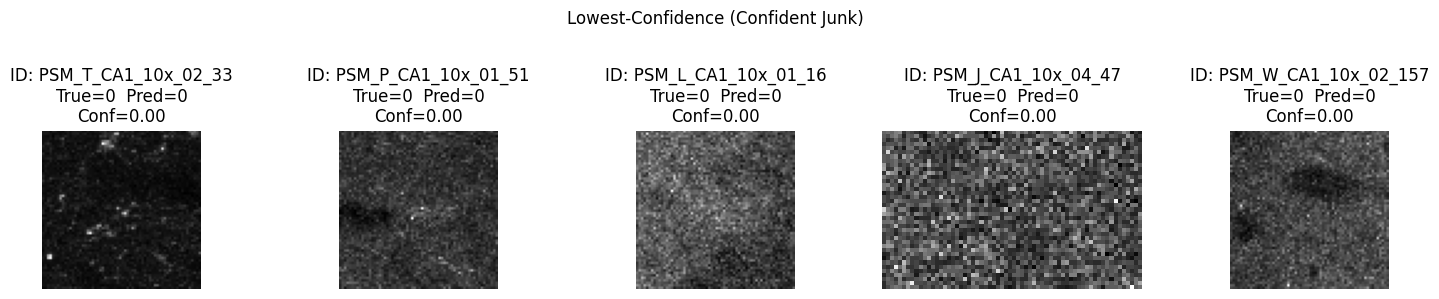

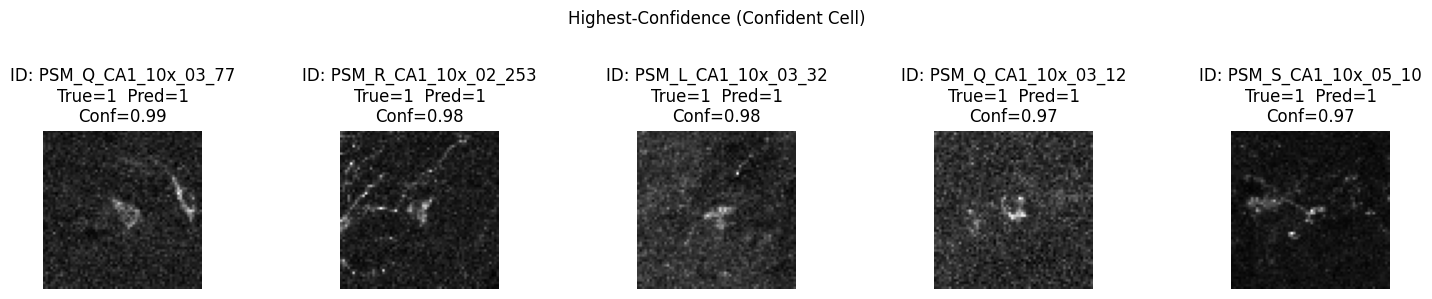

⚠️ No examples to show for 'Confident False Positives'.


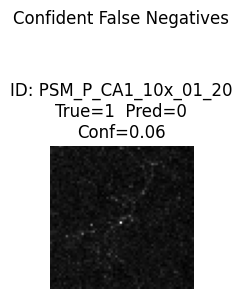

In [133]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ─── Configuration ────────────────────────────────────────────────────────────
MODEL_DIR    = r"D:\PSM\SST_images\SST3\models"
PATCH_DIR    = os.path.join(MODEL_DIR, "patches")
ANNOT_CSV    = os.path.join(MODEL_DIR, "annotated_labels.csv")
FEATURE_FILE = os.path.join(MODEL_DIR, "radiatum_patch_features_combined.parquet")

# ─── Load & Merge Full Annotated DataFrame ────────────────────────────────────
features_df = pd.read_parquet(FEATURE_FILE)
annotations = pd.read_csv(ANNOT_CSV)

# Merge annotated rows (inner join). Detect which column holds the label.
merged = features_df.merge(
    annotations[['patch_id', 'label']],
    on='patch_id',
    how='inner'
)
if 'label' in merged.columns:
    merged.rename(columns={'label': 'true_label'}, inplace=True)
elif 'label_y' in merged.columns:
    merged.rename(columns={'label_y': 'true_label'}, inplace=True)
elif 'label_x' in merged.columns:
    merged.rename(columns={'label_x': 'true_label'}, inplace=True)
else:
    raise ValueError(
        "❌ No label column found after merge. Columns are: " 
        + ", ".join(merged.columns)
    )
merged['true_label'] = merged['true_label'].astype(int)
df_full = merged  # only the annotated patches remain

# ─── Define feature columns ───────────────────────────────────────────────────
feature_cols = [
    'volume', 'intensity', 'texture', 'contrast', 'edge_strength', 'skewness',
    'background_mean', 'background_std', 'background_contrast_ratio',
    'eccentricity', 'solidity', 'extent', 'circularity',
    'major_axis_length', 'minor_axis_length'
]

# ─── Split into train / test, preserving DataFrame form ───────────────────────
train_df, test_df = train_test_split(
    df_full,
    test_size=0.2,
    random_state=42,
    stratify=df_full['true_label']
)

# ─── Prepare test arrays for prediction ───────────────────────────────────────
X_test = test_df[feature_cols].values
y_test = test_df['true_label'].values

# ─── Predict probabilities & classes ─────────────────────────────────────────
y_prob = clf.predict_proba(X_test)[:, 1]       # “Cell” probability
y_pred = (y_prob > 0.5).astype(int)

# ─── Assemble a results DataFrame ─────────────────────────────────────────────
results_df = test_df.copy()
results_df['prob_cell'] = y_prob
results_df['pred']     = y_pred

# ─── Identify lowest / highest confidence examples ────────────────────────────
low_conf_df  = results_df.sort_values(by='prob_cell', ascending=True).head(5)
high_conf_df = results_df.sort_values(by='prob_cell', ascending=False).head(5)

print("📊 Lowest-confidence (most certainly Junk) examples:")
display(low_conf_df[['patch_id','true_label','pred','prob_cell']])

print("\n📊 Highest-confidence (most certainly Cell) examples:")
display(high_conf_df[['patch_id','true_label','pred','prob_cell']])

# ─── Identify confident misclassifications ────────────────────────────────────
# False positives: true_label==0 but pred==1
fp_df = results_df[(results_df['true_label'] == 0) & (results_df['pred'] == 1)]
fp_conf = fp_df.sort_values(by='prob_cell', ascending=False).head(5)

# False negatives: true_label==1 but pred==0
fn_df = results_df[(results_df['true_label'] == 1) & (results_df['pred'] == 0)]
fn_conf = fn_df.sort_values(by='prob_cell', ascending=True).head(5)

print("🚨 Most Confident False Positives (true=Junk, pred=Cell):")
display(fp_conf[['patch_id','true_label','pred','prob_cell']])

print("\n🚨 Most Confident False Negatives (true=Cell, pred=Junk):")
display(fn_conf[['patch_id','true_label','pred','prob_cell']])

# ─── Visualization Helper ─────────────────────────────────────────────────────
def plot_patches(df_subset, title):
    n = len(df_subset)
    if n == 0:
        print(f"⚠️ No examples to show for '{title}'.")
        return

    fig, axes = plt.subplots(1, n, figsize=(n * 3, 3))
    # If only one subplot, wrap in list for uniform indexing
    if n == 1:
        axes = [axes]

    fig.suptitle(title, fontsize=12)
    for i, (_, row) in enumerate(df_subset.iterrows()):
        pid = row['patch_id']
        npy_path = os.path.join(PATCH_DIR, pid + ".npy")
        if not os.path.exists(npy_path):
            axes[i].set_title("Missing")
            axes[i].axis("off")
            continue
        patch_3d = np.load(npy_path)
        mip = patch_3d.max(axis=0)    # max‐projection of the 3D patch
        axes[i].imshow(mip, cmap='gray')
        axes[i].set_title(
            f"ID: {pid}\nTrue={row['true_label']}  Pred={row['pred']}\nConf={row['prob_cell']:.2f}"
        )
        axes[i].axis("off")

    plt.tight_layout(rect=[0,0,1,0.9])
    plt.show()

# ─── Plot all four sets ───────────────────────────────────────────────────────
plot_patches(low_conf_df,  "Lowest‐Confidence (Confident Junk)")
plot_patches(high_conf_df, "Highest‐Confidence (Confident Cell)")
plot_patches(fp_conf,      "Confident False Positives")
plot_patches(fn_conf,      "Confident False Negatives")


In [38]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell 10: Compare Classifier Options (Baseline vs. Class-Weighted RF)
# ─────────────────────────────────────────────────────────────────────────────
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pickle

# ─── Configuration ────────────────────────────────────────────────────────────
MODEL_DIR      = r"D:\PSM\SST_images\SST3\models"
FEATURE_FILE   = os.path.join(MODEL_DIR, "radiatum_patch_features.parquet")
ANNOT_CSV      = os.path.join(MODEL_DIR, "annotated_labels.csv")

# ─── Load and merge features with labels ──────────────────────────────────────
features_df = pd.read_parquet(FEATURE_FILE)
annotations = pd.read_csv(ANNOT_CSV)
df = features_df.merge(annotations, on="patch_id", how="inner")

# ─── Define the feature columns ───────────────────────────────────────────────
feature_cols = [
    'volume', 'intensity', 'texture', 'contrast', 'edge_strength', 'skewness',
    'background_mean', 'background_std', 'background_contrast_ratio',
    'eccentricity', 'solidity', 'extent', 'circularity',
    'major_axis_length', 'minor_axis_length'
]

X = df[feature_cols].values
y = df['label'].values

# ─── Train-test split ─────────────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ─── Define two RandomForest variants ─────────────────────────────────────────
models = {
    "Baseline RF": RandomForestClassifier(n_estimators=100, random_state=42),
    "Balanced RF": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
}

results = {}

for name, clf in models.items():
    # Train
    clf.fit(X_train, y_train)
    # Predictions
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]
    # Metrics
    report = classification_report(y_test, y_pred, target_names=['Junk', 'Cell'], zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    cv_scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
    # Feature importances
    feat_imp = pd.Series(clf.feature_importances_, index=feature_cols).sort_values(ascending=False)
    # Store
    results[name] = {
        "clf": clf,
        "report": report,
        "confusion_matrix": cm,
        "roc_auc": roc_auc,
        "cv_auc": cv_scores,
        "feature_importances": feat_imp
    }

# ─── Print comparison ─────────────────────────────────────────────────────────
for name, res in results.items():
    print(f"\n=== {name} ===")
    print("Classification Report:\n", res["report"])
    print("Confusion Matrix:\n", res["confusion_matrix"])
    print(f"ROC AUC: {res['roc_auc']:.3f}")
    print(f"5-fold CV AUC: {res['cv_auc'].mean():.3f} ± {res['cv_auc'].std():.3f}\n")
    print("🔍 Feature Importances (highest → lowest):")
    for i, (feat, score) in enumerate(res["feature_importances"].items(), start=1):
        print(f" {i:2}. {feat:<20} {score:.4f}")
    print("\n" + "─" * 60)

# ─── (Optional) Save the best model ────────────────────────────────────────────
# Example: choose Balanced RF if its CV AUC is higher
best_model_name = max(results, key=lambda n: results[n]["cv_auc"].mean())
best_clf = results[best_model_name]["clf"]
with open(os.path.join(MODEL_DIR, f"rf_radiatum_{best_model_name.replace(' ', '_')}.pkl"), "wb") as f:
    pickle.dump(best_clf, f)
print(f"\n✅ Saved best model (‘{best_model_name}’) to disk.") 



=== Baseline RF ===
Classification Report:
               precision    recall  f1-score   support

        Junk       0.80      0.89      0.84        44
        Cell       0.55      0.38      0.44        16

    accuracy                           0.75        60
   macro avg       0.67      0.63      0.64        60
weighted avg       0.73      0.75      0.73        60

Confusion Matrix:
 [[39  5]
 [10  6]]
ROC AUC: 0.748
5-fold CV AUC: 0.626 ± 0.149

🔍 Feature Importances (highest → lowest):
  1. volume               0.1106
  2. circularity          0.0843
  3. minor_axis_length    0.0800
  4. major_axis_length    0.0787
  5. edge_strength        0.0757
  6. background_contrast_ratio 0.0687
  7. contrast             0.0663
  8. background_std       0.0636
  9. intensity            0.0623
 10. solidity             0.0598
 11. skewness             0.0573
 12. background_mean      0.0547
 13. eccentricity         0.0483
 14. texture              0.0456
 15. extent               0.0440

──